#### Challenge: Factors that affect life expectancy

data source: https://www.kaggle.com/kumarajarshi/life-expectancy-who/home

##### Challenge:
Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

1. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

2. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

3. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

4. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from matplotlib.mlab import PCA as mlabPCA
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from scipy.stats.stats import ttest_ind
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings


warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)


engine.dispose()

##### question 1
Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

###### nonesense values
A review of the head reveals possible data collection errors. For example, under percentage expenditure, in row 4 the value is 10x less than the first 4 values and the next value. In the same column, in row 10, the same issue occurs. Under Adult Mortality, the same type error occurs in row 13. It is likely there are many more such errors which would make these values outliers, to be dealth with in the outlier transformation phase. 

In [2]:
lifeexpectancy_df.head(20)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [3]:
lifeexpectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
lifeexpectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


###### missing values

In [5]:
lifeexpectancy_df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [6]:
lifeexpectancy_df.nunique()

Country                             193
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2328
Hepatitis B                          87
Measles                             958
 BMI                                608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
 HIV/AIDS                           200
GDP                                2490
Population                         2278
 thinness  1-19 years               200
 thinness 5-9 years                 207
Income composition of resources     625
Schooling                           173
dtype: int64

In [7]:
lifeexpectancy_df.columns.unique()

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [8]:
#fix trailing/leading white space
lifeexpectancy_df.columns = lifeexpectancy_df.columns.str.strip()

In [9]:
lifeexpectancy_df.columns.unique()

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [10]:
#fill in missing values: groupby Country to improve accuracy of interpolation
fill_list = ['Life expectancy', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 
             'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'GDP', 
             'Population', 'thinness  1-19 years', 'thinness 5-9 years', 
             'Income composition of resources', 'Schooling'] 

for country in lifeexpectancy_df['Country'].unique():
    for column in fill_list:
        lifeexpectancy_df.loc[:, column] = lifeexpectancy_df.loc[:, column].interpolate()

In [11]:
lifeexpectancy_df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

In [12]:
lifeexpectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,30.303948,4.548919,738.251295,78.536419,2419.592240,38.29869,42.035739,82.474643,5.940955,82.246086,1.742103,7432.027910,1.229209e+07,4.882301,4.920439,0.634458,12.076804
std,4.613841,9.510819,124.226596,117.926501,3.994854,1987.914858,25.177963,11467.272489,19.99140,160.445548,23.420689,2.445751,23.705664,5.077785,13410.150286,5.471908e+07,4.433359,4.532488,0.209574,3.342316
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,78.000000,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,0.500000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,93.000000,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,97.000000,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,0.791107,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.30000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


###### outliers
will run zscore & IQR for comparison

In [13]:
#zscore
outliers = []

columns = lifeexpectancy_df.select_dtypes(exclude=['object']).columns.tolist()
print(columns)

for i in columns:
    threshold = 3 
    z_scores = zscore(lifeexpectancy_df[i])

    for threshold in range(3,5):
        print(i)  
        print('The score threshold is: {}'.format(threshold))
        print('Number of outliers is: {}'.format(len((np.where(z_scores > threshold)[0]))))
    

['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']
Year
The score threshold is: 3
Number of outliers is: 0
Year
The score threshold is: 4
Number of outliers is: 0
Life expectancy
The score threshold is: 3
Number of outliers is: 0
Life expectancy
The score threshold is: 4
Number of outliers is: 0
Adult Mortality
The score threshold is: 3
Number of outliers is: 40
Adult Mortality
The score threshold is: 4
Number of outliers is: 11
infant deaths
The score threshold is: 3
Number of outliers is: 37
infant deaths
The score threshold is: 4
Number of outliers is: 29
Alcohol
The score threshold is: 3
Number of outliers is: 4
Alcohol
The score threshold is: 4
Number of outliers is: 0
percentage expenditure
The score threshold

In [14]:
#iqr
columns = lifeexpectancy_df.select_dtypes(exclude=['object']).columns.tolist()
print(columns)

for i in columns:
    threshold = 3 
    q75, q25 = np.percentile(lifeexpectancy_df[i], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(3,5,1):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print(i)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(
            len((np.where((lifeexpectancy_df[i] > max_val) 
                      | (lifeexpectancy_df[i] < min_val))[0]))
        ))

['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']
Year
The score threshold is: 3
Number of outliers is: 0
Year
The score threshold is: 4
Number of outliers is: 0
Life expectancy
The score threshold is: 3
Number of outliers is: 0
Life expectancy
The score threshold is: 4
Number of outliers is: 0
Adult Mortality
The score threshold is: 3
Number of outliers is: 5
Adult Mortality
The score threshold is: 4
Number of outliers is: 0
infant deaths
The score threshold is: 3
Number of outliers is: 158
infant deaths
The score threshold is: 4
Number of outliers is: 130
Alcohol
The score threshold is: 3
Number of outliers is: 0
Alcohol
The score threshold is: 4
Number of outliers is: 0
percentage expenditure
The score threshold

##### transform outliers

In [15]:
outliers = ['Adult Mortality', 'infant deaths', 'Alcohol', 
            'percentage expenditure', 'Measles', 'under-five deaths', 
            'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 
            'GDP', 'Population', 'thinness  1-19 years', 
            'thinness 5-9 years']

In [16]:
for outlier in outliers:
    lifeexpectancy_df['winsorized_'+ outlier] = winsorize(lifeexpectancy_df[outlier], (0, 0.05))

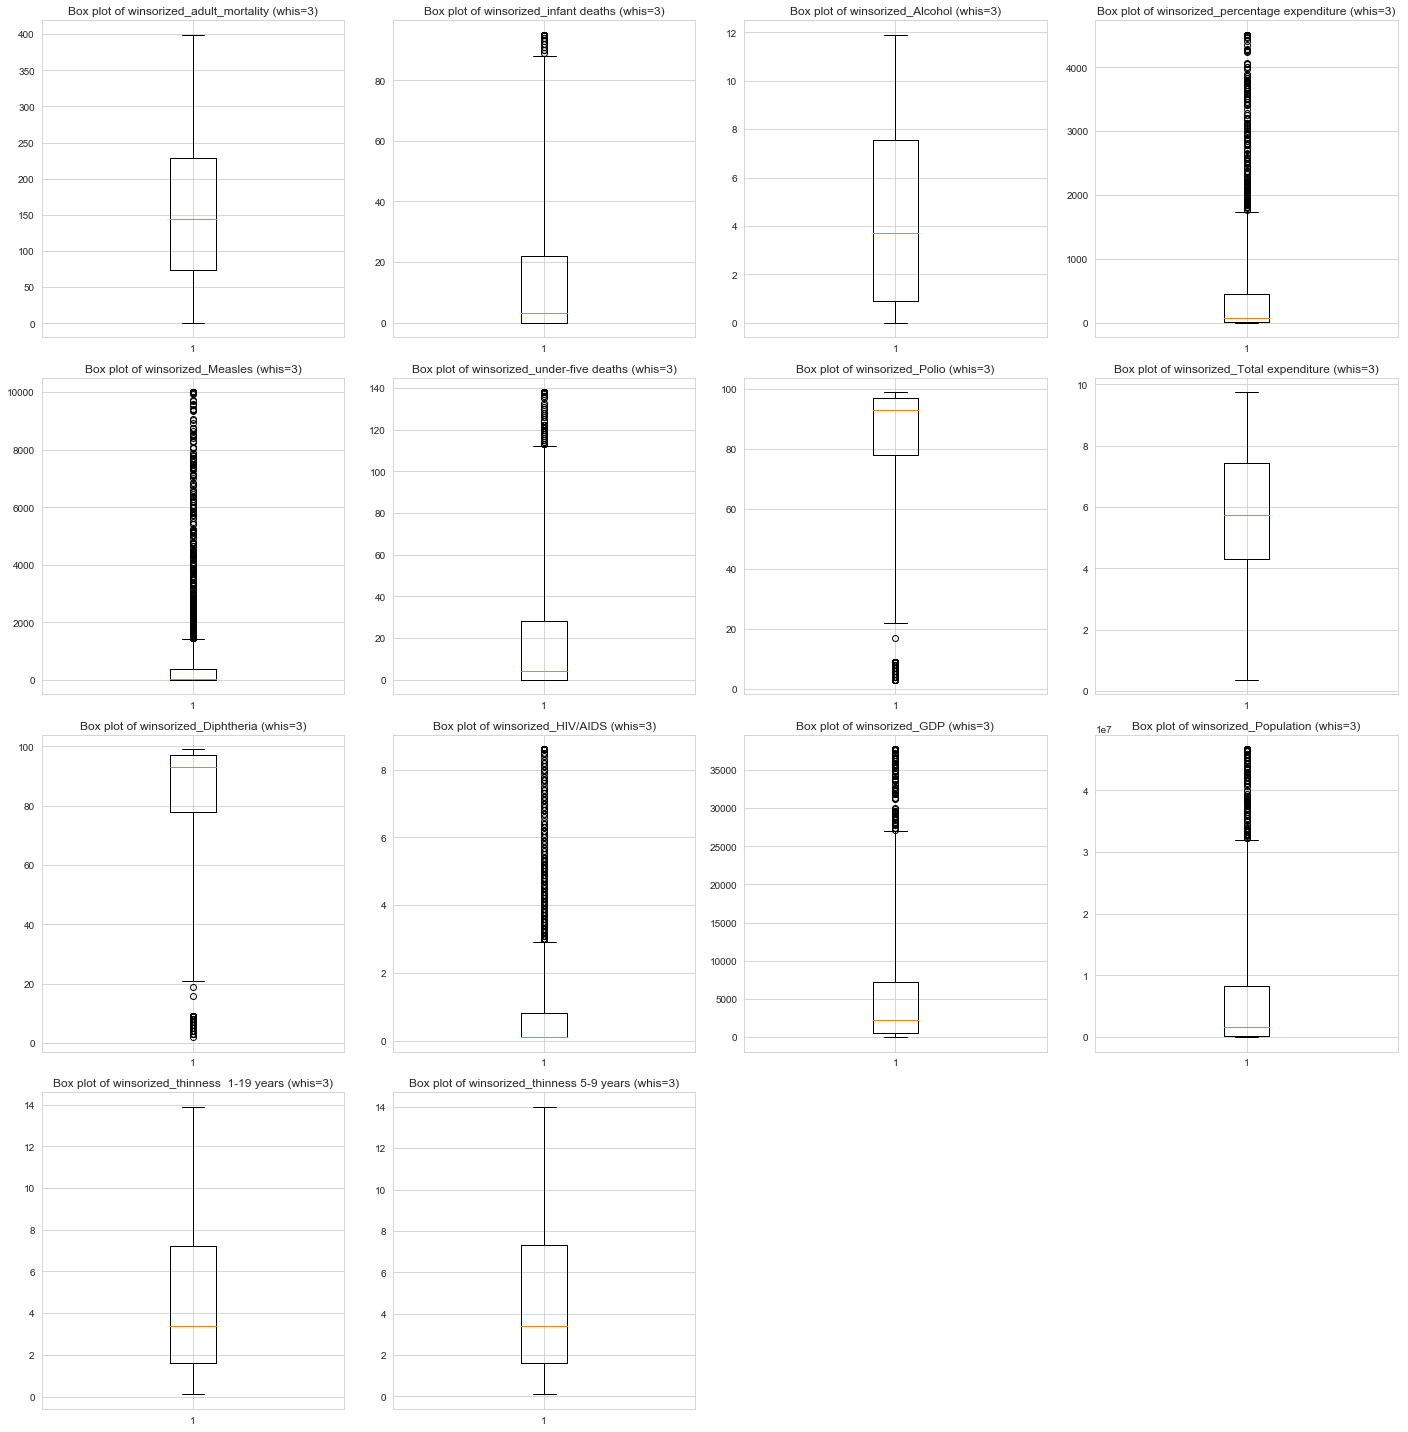

In [17]:
plt.figure(figsize=(20,20))

plt.subplot(4,4,1)
plt.boxplot(lifeexpectancy_df['winsorized_Adult Mortality'], whis=3)
plt.title("Box plot of winsorized_adult_mortality (whis=3)")

plt.subplot(4,4,2)
plt.boxplot(lifeexpectancy_df['winsorized_infant deaths'], whis=3)
plt.title("Box plot of winsorized_infant deaths (whis=3)")

plt.subplot(4,4,3)
plt.boxplot(lifeexpectancy_df['winsorized_Alcohol'], whis=3)
plt.title("Box plot of winsorized_Alcohol (whis=3)")

plt.subplot(4,4,4)
plt.boxplot(lifeexpectancy_df['winsorized_percentage expenditure'], whis=3)
plt.title("Box plot of winsorized_percentage expenditure (whis=3)")

plt.subplot(4,4,5)
plt.boxplot(lifeexpectancy_df['winsorized_Measles'], whis=3)
plt.title("Box plot of winsorized_Measles (whis=3)")

plt.subplot(4,4,6)
plt.boxplot(lifeexpectancy_df['winsorized_under-five deaths'],whis=3 )
plt.title("Box plot of winsorized_under-five deaths (whis=3)")

plt.subplot(4,4,7)
plt.boxplot(lifeexpectancy_df['winsorized_Polio'], whis=3)
plt.title("Box plot of winsorized_Polio (whis=3)")

plt.subplot(4,4,8)
plt.boxplot(lifeexpectancy_df['winsorized_Total expenditure'], whis=3)
plt.title("Box plot of winsorized_Total expenditure (whis=3)")

plt.subplot(4,4,9)
plt.boxplot(lifeexpectancy_df['winsorized_Diphtheria'], whis=3)
plt.title("Box plot of winsorized_Diphtheria (whis=3)")

plt.subplot(4,4,10)
plt.boxplot(lifeexpectancy_df['winsorized_HIV/AIDS'], whis=3)
plt.title("Box plot of winsorized_HIV/AIDS (whis=3)")

plt.subplot(4,4,11)
plt.boxplot(lifeexpectancy_df['winsorized_GDP'], whis=3)
plt.title("Box plot of winsorized_GDP (whis=3)")

plt.subplot(4,4,12)
plt.boxplot(lifeexpectancy_df['winsorized_Population'], whis=3)
plt.title("Box plot of winsorized_Population (whis=3)")

plt.subplot(4,4,13)
plt.boxplot(lifeexpectancy_df['winsorized_thinness  1-19 years'], whis=3)
plt.title("Box plot of winsorized_thinness  1-19 years (whis=3)")

plt.subplot(4,4,14)
plt.boxplot(lifeexpectancy_df['winsorized_thinness 5-9 years'],whis=3 )
plt.title("Box plot of winsorized_thinness 5-9 years (whis=3)")


plt.tight_layout()
plt.show()

In [18]:
#adjustments for variables with remaining outliers

outliers = ['infant deaths', 'percentage expenditure', 
            'Measles', 'under-five deaths', 'Polio', 
            'Diphtheria', 'HIV/AIDS', 
            'GDP', 'Population']

for outlier in outliers:
    lifeexpectancy_df['winsorized_'+ outlier] = winsorize(lifeexpectancy_df[outlier], (0.10, 0.10))
    

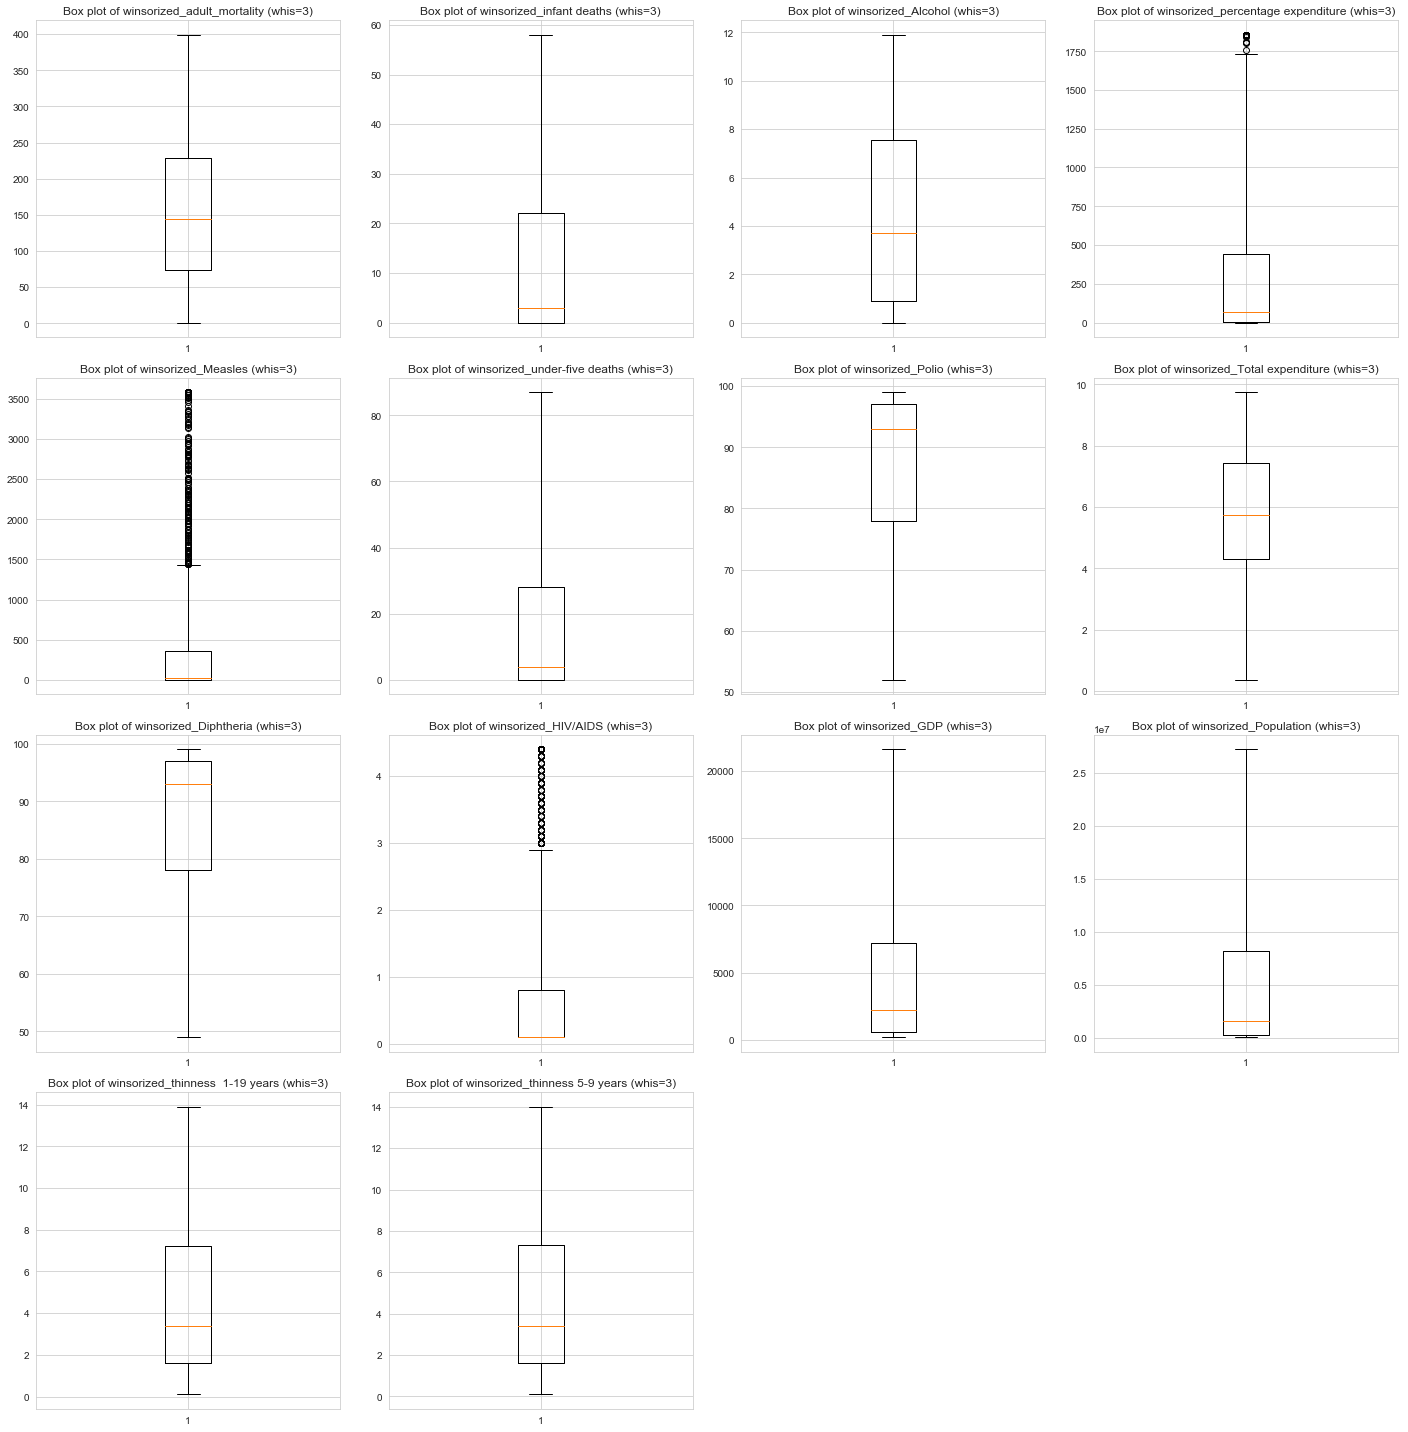

In [19]:
plt.figure(figsize=(20,20))

plt.subplot(4,4,1)
plt.boxplot(lifeexpectancy_df['winsorized_Adult Mortality'], whis=3)
plt.title("Box plot of winsorized_adult_mortality (whis=3)")

plt.subplot(4,4,2)
plt.boxplot(lifeexpectancy_df['winsorized_infant deaths'], whis=3)
plt.title("Box plot of winsorized_infant deaths (whis=3)")

plt.subplot(4,4,3)
plt.boxplot(lifeexpectancy_df['winsorized_Alcohol'], whis=3)
plt.title("Box plot of winsorized_Alcohol (whis=3)")

plt.subplot(4,4,4)
plt.boxplot(lifeexpectancy_df['winsorized_percentage expenditure'], whis=3)
plt.title("Box plot of winsorized_percentage expenditure (whis=3)")

plt.subplot(4,4,5)
plt.boxplot(lifeexpectancy_df['winsorized_Measles'], whis=3)
plt.title("Box plot of winsorized_Measles (whis=3)")

plt.subplot(4,4,6)
plt.boxplot(lifeexpectancy_df['winsorized_under-five deaths'],whis=3 )
plt.title("Box plot of winsorized_under-five deaths (whis=3)")

plt.subplot(4,4,7)
plt.boxplot(lifeexpectancy_df['winsorized_Polio'], whis=3)
plt.title("Box plot of winsorized_Polio (whis=3)")

plt.subplot(4,4,8)
plt.boxplot(lifeexpectancy_df['winsorized_Total expenditure'], whis=3)
plt.title("Box plot of winsorized_Total expenditure (whis=3)")

plt.subplot(4,4,9)
plt.boxplot(lifeexpectancy_df['winsorized_Diphtheria'], whis=3)
plt.title("Box plot of winsorized_Diphtheria (whis=3)")

plt.subplot(4,4,10)
plt.boxplot(lifeexpectancy_df['winsorized_HIV/AIDS'], whis=3)
plt.title("Box plot of winsorized_HIV/AIDS (whis=3)")

plt.subplot(4,4,11)
plt.boxplot(lifeexpectancy_df['winsorized_GDP'], whis=3)
plt.title("Box plot of winsorized_GDP (whis=3)")

plt.subplot(4,4,12)
plt.boxplot(lifeexpectancy_df['winsorized_Population'], whis=3)
plt.title("Box plot of winsorized_Population (whis=3)")

plt.subplot(4,4,13)
plt.boxplot(lifeexpectancy_df['winsorized_thinness  1-19 years'], whis=3)
plt.title("Box plot of winsorized_thinness  1-19 years (whis=3)")

plt.subplot(4,4,14)
plt.boxplot(lifeexpectancy_df['winsorized_thinness 5-9 years'],whis=3 )
plt.title("Box plot of winsorized_thinness 5-9 years (whis=3)")


plt.tight_layout()
plt.show()

recheck zscore & IQR for outliers

In [20]:
outliers = []

columns = lifeexpectancy_df.select_dtypes(exclude=['object']).columns.tolist()
print(columns)

for i in columns:
    threshold = 3 
    z_scores = zscore(lifeexpectancy_df[i])

    for threshold in range(3,5):
        print(i)  
        print('The score threshold is: {}'.format(threshold))
        print('Number of outliers is: {}'.format(len((np.where(z_scores > threshold)[0]))))

['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'winsorized_Adult Mortality', 'winsorized_infant deaths', 'winsorized_Alcohol', 'winsorized_percentage expenditure', 'winsorized_Measles', 'winsorized_under-five deaths', 'winsorized_Polio', 'winsorized_Total expenditure', 'winsorized_Diphtheria', 'winsorized_HIV/AIDS', 'winsorized_GDP', 'winsorized_Population', 'winsorized_thinness  1-19 years', 'winsorized_thinness 5-9 years']
Year
The score threshold is: 3
Number of outliers is: 0
Year
The score threshold is: 4
Number of outliers is: 0
Life expectancy
The score threshold is: 3
Number of outliers is: 0
Life expectancy
The score threshold is: 4
Number of outliers is: 0
Adult Mortality
The score threshold is: 3
Numb

In [21]:
columns = lifeexpectancy_df.select_dtypes(exclude=['object']).columns.tolist()
print(columns)

for i in columns:
    threshold = 3 
    q75, q25 = np.percentile(lifeexpectancy_df[i], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(3,5,1):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print(i)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(
            len((np.where((lifeexpectancy_df[i] > max_val) 
                      | (lifeexpectancy_df[i] < min_val))[0]))
        ))

['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'winsorized_Adult Mortality', 'winsorized_infant deaths', 'winsorized_Alcohol', 'winsorized_percentage expenditure', 'winsorized_Measles', 'winsorized_under-five deaths', 'winsorized_Polio', 'winsorized_Total expenditure', 'winsorized_Diphtheria', 'winsorized_HIV/AIDS', 'winsorized_GDP', 'winsorized_Population', 'winsorized_thinness  1-19 years', 'winsorized_thinness 5-9 years']
Year
The score threshold is: 3
Number of outliers is: 0
Year
The score threshold is: 4
Number of outliers is: 0
Life expectancy
The score threshold is: 3
Number of outliers is: 0
Life expectancy
The score threshold is: 4
Number of outliers is: 0
Adult Mortality
The score threshold is: 3
Numb

After winsorization, 3 variables remain with outliers. Will log_transform these variables. 

In [22]:

lifeexpectancy_df['log_percentage expenditure'] = np.log(lifeexpectancy_df['percentage expenditure'])
lifeexpectancy_df['log_Measles'] = np.log(lifeexpectancy_df['Measles'])

lifeexpectancy_df['log_HIV/AIDS'] = np.log(lifeexpectancy_df['HIV/AIDS'])


In [23]:
columns = lifeexpectancy_df.select_dtypes(exclude=['object']).columns.tolist()
print(columns)

for i in columns:
    threshold = 3 
    q75, q25 = np.percentile(lifeexpectancy_df[i], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(3,5,1):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print(i)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(
            len((np.where((lifeexpectancy_df[i] > max_val) 
                      | (lifeexpectancy_df[i] < min_val))[0]))
        ))

['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'winsorized_Adult Mortality', 'winsorized_infant deaths', 'winsorized_Alcohol', 'winsorized_percentage expenditure', 'winsorized_Measles', 'winsorized_under-five deaths', 'winsorized_Polio', 'winsorized_Total expenditure', 'winsorized_Diphtheria', 'winsorized_HIV/AIDS', 'winsorized_GDP', 'winsorized_Population', 'winsorized_thinness  1-19 years', 'winsorized_thinness 5-9 years', 'log_percentage expenditure', 'log_Measles', 'log_HIV/AIDS']
Year
The score threshold is: 3
Number of outliers is: 0
Year
The score threshold is: 4
Number of outliers is: 0
Life expectancy
The score threshold is: 3
Number of outliers is: 0
Life expectancy
The score threshold is: 4
Number of 

###### still have 1222 outliers for percentage_expenditure after log transfrom but only 304 after winsor transform; will use winsor transform for this variable.
question: is there a way or should another transformation be used to eliminate these outliers beyond winsor?

##### question 2 
Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [24]:
lifeexpectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,winsorized_Total expenditure,winsorized_Diphtheria,winsorized_HIV/AIDS,winsorized_GDP,winsorized_Population,winsorized_thinness 1-19 years,winsorized_thinness 5-9 years,log_percentage expenditure,log_Measles,log_HIV/AIDS
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,30.303948,4.548919,738.251295,78.536419,2419.592240,38.29869,42.035739,...,5.840851,85.118740,0.878863,5446.912581,6.206396e+06,4.687969,4.704700,-inf,-inf,-1.221949
std,4.613841,9.510819,124.226596,117.926501,3.994854,1987.914858,25.177963,11467.272489,19.99140,160.445548,...,2.197031,15.963752,1.433147,6921.157287,8.834519e+06,3.823343,3.853879,NaN,NaN,1.613377
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,...,0.370000,49.000000,0.100000,193.794956,4.516300e+04,0.100000,0.100000,-inf,-inf,-2.302585
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,...,4.312500,78.000000,0.100000,553.618620,2.536025e+05,1.600000,1.600000,1.544430,-inf,-2.302585
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,...,5.760000,93.000000,0.100000,2192.681084,1.576319e+06,3.400000,3.400000,4.173046,2.833213,-2.302585
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,...,7.440000,97.000000,0.800000,7183.381694,8.215738e+06,7.200000,7.300000,6.090255,5.886792,-0.223144
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.30000,2500.000000,...,9.750000,99.000000,4.400000,21618.735340,2.721238e+07,13.900000,14.000000,9.877139,12.265204,3.923952


The log versions of percentage_expenditure and Measles appear to be unusable for our purposes. Will use winsorized values for all variable except for possibly HIV/AIDS?

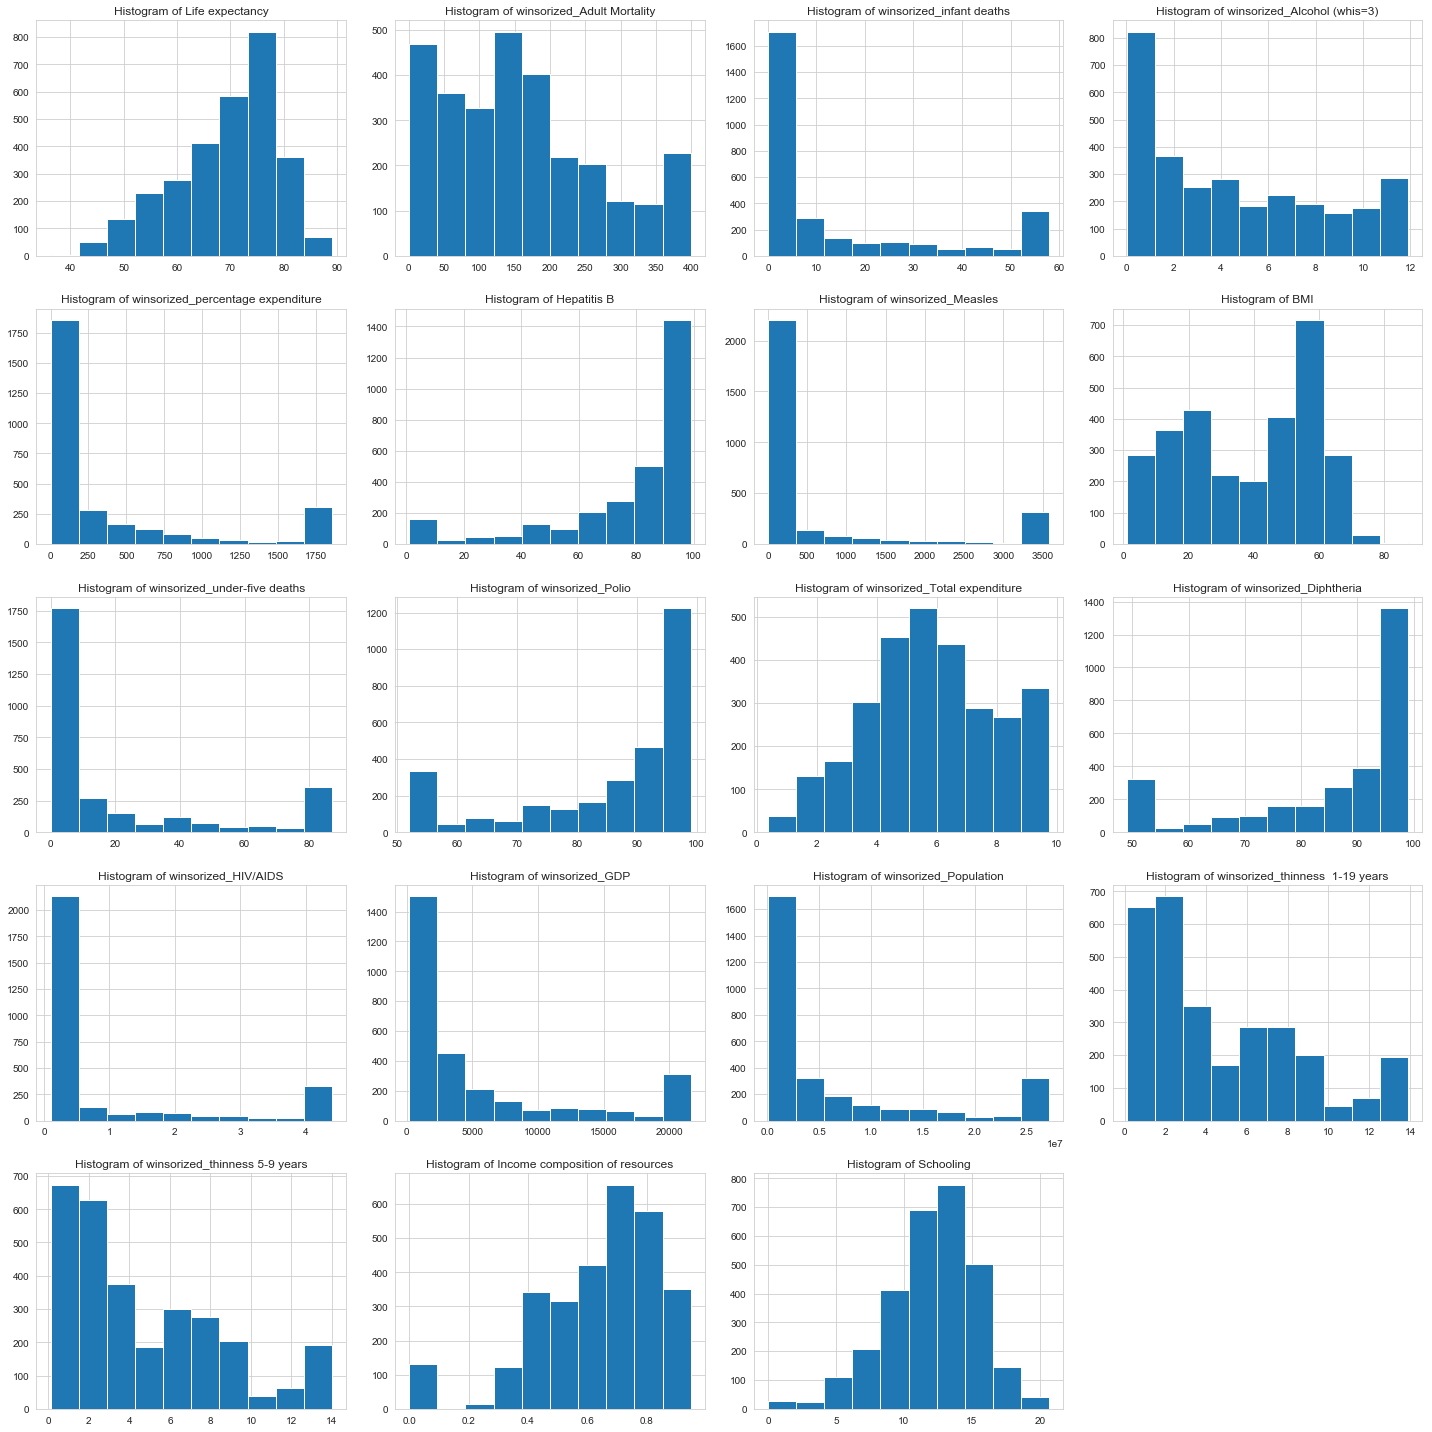

In [25]:
plt.figure(figsize=(20,20))

plt.subplot(5,4,1)
plt.hist(lifeexpectancy_df['Life expectancy'])
plt.title("Histogram of Life expectancy")

plt.subplot(5,4,2)
plt.hist(lifeexpectancy_df['winsorized_Adult Mortality'])
plt.title("Histogram of winsorized_Adult Mortality")

plt.subplot(5,4,3)
plt.hist(lifeexpectancy_df['winsorized_infant deaths'])
plt.title("Histogram of winsorized_infant deaths")

plt.subplot(5,4,4)
plt.hist(lifeexpectancy_df['winsorized_Alcohol'])
plt.title("Histogram of winsorized_Alcohol (whis=3)")

plt.subplot(5,4,5)
plt.hist(lifeexpectancy_df['winsorized_percentage expenditure'])
plt.title("Histogram of winsorized_percentage expenditure")

plt.subplot(5,4,6)
plt.hist(lifeexpectancy_df['Hepatitis B'])
plt.title("Histogram of Hepatitis B")

plt.subplot(5,4,7)
plt.hist(lifeexpectancy_df['winsorized_Measles'])
plt.title("Histogram of winsorized_Measles")

plt.subplot(5,4,8)
plt.hist(lifeexpectancy_df['BMI'])
plt.title("Histogram of BMI")

plt.subplot(5,4,9)
plt.hist(lifeexpectancy_df['winsorized_under-five deaths'])
plt.title("Histogram of winsorized_under-five deaths")

plt.subplot(5,4,10)
plt.hist(lifeexpectancy_df['winsorized_Polio'])
plt.title("Histogram of winsorized_Polio")

plt.subplot(5,4,11)
plt.hist(lifeexpectancy_df['winsorized_Total expenditure'])
plt.title("Histogram of winsorized_Total expenditure")

plt.subplot(5,4,12)
plt.hist(lifeexpectancy_df['winsorized_Diphtheria'])
plt.title("Histogram of winsorized_Diphtheria")

plt.subplot(5,4,13)
plt.hist(lifeexpectancy_df['winsorized_HIV/AIDS'])
plt.title("Histogram of winsorized_HIV/AIDS")

plt.subplot(5,4,14)
plt.hist(lifeexpectancy_df['winsorized_GDP'])
plt.title("Histogram of winsorized_GDP")

plt.subplot(5,4,15)
plt.hist(lifeexpectancy_df['winsorized_Population'])
plt.title("Histogram of winsorized_Population")

plt.subplot(5,4,16)
plt.hist(lifeexpectancy_df['winsorized_thinness  1-19 years'])
plt.title("Histogram of winsorized_thinness  1-19 years")

plt.subplot(5,4,17)
plt.hist(lifeexpectancy_df['winsorized_thinness 5-9 years'])
plt.title("Histogram of winsorized_thinness 5-9 years")

plt.subplot(5,4,18)
plt.hist(lifeexpectancy_df['Income composition of resources'])
plt.title("Histogram of Income composition of resources")

plt.subplot(5,4,19)
plt.hist(lifeexpectancy_df['Schooling'])
plt.title("Histogram of Schooling")


plt.tight_layout()
plt.show()

NONE of the variables have a normal distribution. Will run log transform on all variables to compare

In [26]:
outliers = ['Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 
            'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI',
            'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 
            'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 
            'thinness 5-9 years', 'Income composition of resources', 'Schooling']

for outlier in outliers:
    lifeexpectancy_df['log_'+ outlier] = np.log(lifeexpectancy_df[outlier])

In [27]:
lifeexpectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log_under-five deaths,log_Polio,log_Total expenditure,log_Diphtheria,log_GDP,log_Population,log_thinness 1-19 years,log_thinness 5-9 years,log_Income composition of resources,log_Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.214874,164.744554,30.303948,4.548919,738.251295,78.536419,2419.592240,38.29869,42.035739,...,-inf,4.304552,1.683981,4.299369,7.593626,14.060290,1.139079,1.128091,-inf,-inf
std,4.613841,9.510819,124.226596,117.926501,3.994854,1987.914858,25.177963,11467.272489,19.99140,160.445548,...,NaN,0.617272,0.474496,0.622426,1.814503,2.553151,1.043731,1.077558,NaN,NaN
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.00000,0.000000,...,-inf,1.098612,-0.994252,0.693147,0.519597,3.526361,-2.302585,-2.302585,-inf,-inf
25%,2004.000000,63.100000,74.000000,0.000000,0.902500,4.685343,71.000000,0.000000,19.32500,0.000000,...,-inf,4.356709,1.461517,4.356709,6.316476,12.443518,0.470004,0.470004,-0.693147,2.322388
50%,2008.000000,72.000000,144.000000,3.000000,3.697500,64.912906,89.000000,17.000000,43.25000,4.000000,...,1.386294,4.532599,1.750937,4.532599,7.692880,14.270603,1.223775,1.223775,-0.379797,2.517696
75%,2012.000000,75.600000,228.000000,22.000000,7.550000,441.534144,96.000000,360.250000,56.10000,28.000000,...,3.332205,4.574711,2.006871,4.574711,8.879525,15.921562,1.974081,1.987874,-0.234322,2.660260
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.30000,2500.000000,...,7.824046,4.595120,2.867899,4.595120,11.688329,20.980895,3.321432,3.353407,-0.053401,3.030134


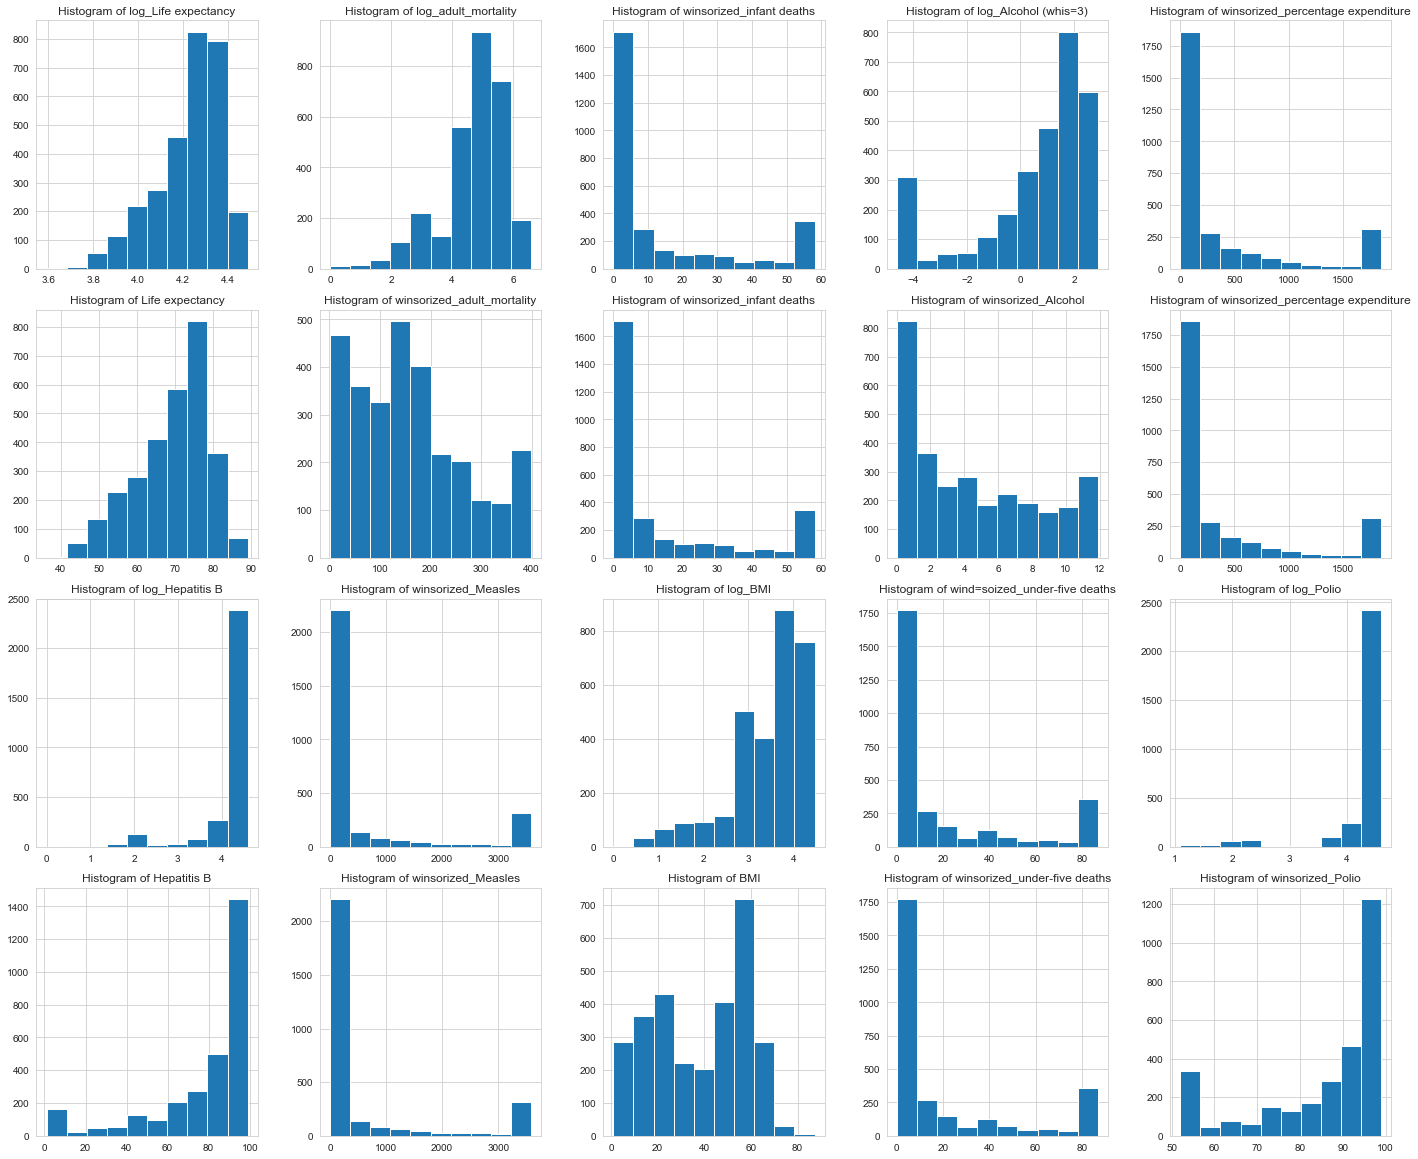

In [28]:
plt.figure(figsize=(20,20))

plt.subplot(5,5,1)
plt.hist(lifeexpectancy_df['log_Life expectancy'])
plt.title("Histogram of log_Life expectancy")

plt.subplot(5,5,2)
plt.hist(lifeexpectancy_df['log_Adult Mortality'])
plt.title("Histogram of log_adult_mortality")

plt.subplot(5,5,3)
plt.hist(lifeexpectancy_df['winsorized_infant deaths'])
plt.title("Histogram of winsorized_infant deaths")

plt.subplot(5,5,4)
plt.hist(lifeexpectancy_df['log_Alcohol'])
plt.title("Histogram of log_Alcohol (whis=3)")

plt.subplot(5,5,5)
plt.hist(lifeexpectancy_df['winsorized_percentage expenditure'])
plt.title("Histogram of winsorized_percentage expenditure")

plt.subplot(5,5,6)
plt.hist(lifeexpectancy_df['Life expectancy'])
plt.title("Histogram of Life expectancy")

plt.subplot(5,5,7)
plt.hist(lifeexpectancy_df['winsorized_Adult Mortality'])
plt.title("Histogram of winsorized_adult_mortality")

plt.subplot(5,5,8)
plt.hist(lifeexpectancy_df['winsorized_infant deaths'])
plt.title("Histogram of winsorized_infant deaths")

plt.subplot(5,5,9)
plt.hist(lifeexpectancy_df['winsorized_Alcohol'])
plt.title("Histogram of winsorized_Alcohol")

plt.subplot(5,5,10)
plt.hist(lifeexpectancy_df['winsorized_percentage expenditure'])
plt.title("Histogram of winsorized_percentage expenditure")

plt.subplot(5,5,11)
plt.hist(lifeexpectancy_df['log_Hepatitis B'])
plt.title("Histogram of log_Hepatitis B")

plt.subplot(5,5,12)
plt.hist(lifeexpectancy_df['winsorized_Measles'])
plt.title("Histogram of winsorized_Measles")


plt.subplot(5,5,13)
plt.hist(lifeexpectancy_df['log_BMI'])
plt.title("Histogram of log_BMI")

plt.subplot(5,5,14)
plt.hist(lifeexpectancy_df['winsorized_under-five deaths'])
plt.title("Histogram of wind=soized_under-five deaths")

plt.subplot(5,5,15)
plt.hist(lifeexpectancy_df['log_Polio'])
plt.title("Histogram of log_Polio")

plt.subplot(5,5,16)
plt.hist(lifeexpectancy_df['Hepatitis B'])
plt.title("Histogram of Hepatitis B")

plt.subplot(5,5,17)
plt.hist(lifeexpectancy_df['winsorized_Measles'])
plt.title("Histogram of winsorized_Measles")

plt.subplot(5,5,18)
plt.hist(lifeexpectancy_df['BMI'])
plt.title("Histogram of BMI")

plt.subplot(5,5,19)
plt.hist(lifeexpectancy_df['winsorized_under-five deaths'])
plt.title("Histogram of winsorized_under-five deaths")

plt.subplot(5,5,20)
plt.hist(lifeexpectancy_df['winsorized_Polio'])
plt.title("Histogram of winsorized_Polio")

plt.tight_layout()
plt.show()

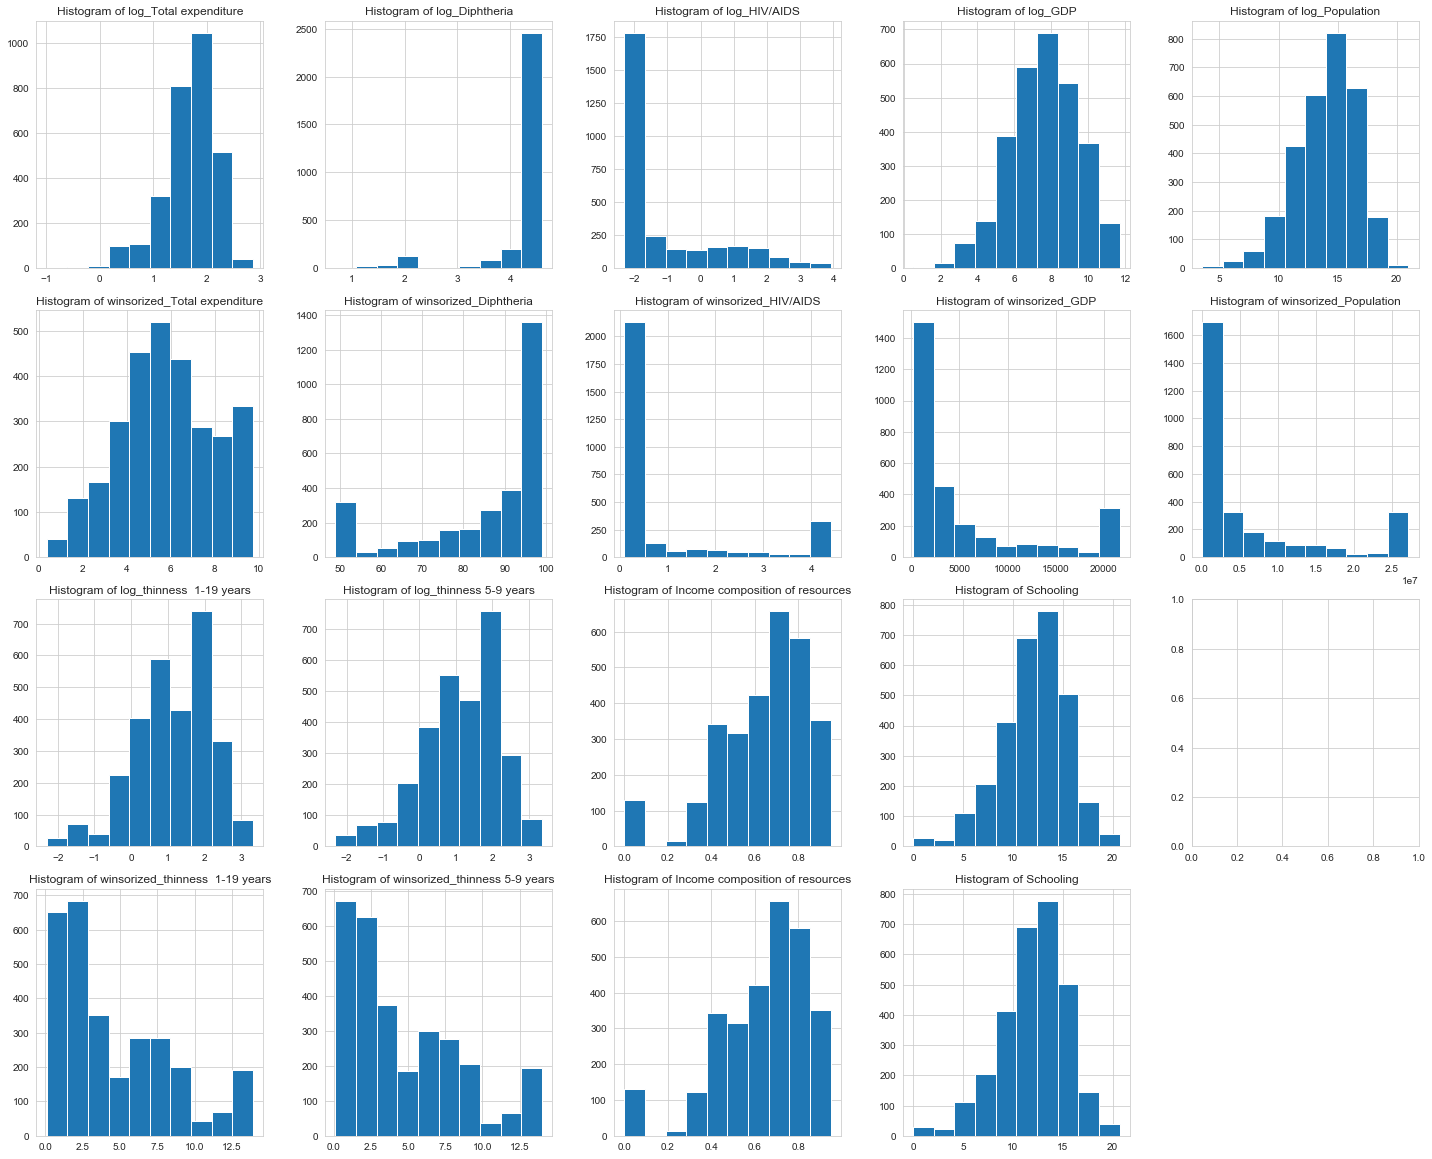

In [29]:
plt.figure(figsize=(20,20))

plt.subplot(5,5,1)
plt.hist(lifeexpectancy_df['log_Total expenditure'])
plt.title("Histogram of log_Total expenditure")

plt.subplot(5,5,2)
plt.hist(lifeexpectancy_df['log_Diphtheria'])
plt.title("Histogram of log_Diphtheria")

plt.subplot(5,5,3)
plt.hist(lifeexpectancy_df['log_HIV/AIDS'])
plt.title("Histogram of log_HIV/AIDS")

plt.subplot(5,5,4)
plt.hist(lifeexpectancy_df['log_GDP'])
plt.title("Histogram of log_GDP")

plt.subplot(5,5,5)
plt.hist(lifeexpectancy_df['log_Population'])
plt.title("Histogram of log_Population")

plt.subplot(5,5,6)
plt.hist(lifeexpectancy_df['winsorized_Total expenditure'])
plt.title("Histogram of winsorized_Total expenditure")

plt.subplot(5,5,7)
plt.hist(lifeexpectancy_df['winsorized_Diphtheria'])
plt.title("Histogram of winsorized_Diphtheria")

plt.subplot(5,5,8)
plt.hist(lifeexpectancy_df['winsorized_HIV/AIDS'])
plt.title("Histogram of winsorized_HIV/AIDS")

plt.subplot(5,5,9)
plt.hist(lifeexpectancy_df['winsorized_GDP'])
plt.title("Histogram of winsorized_GDP")

plt.subplot(5,5,10)
plt.hist(lifeexpectancy_df['winsorized_Population'])
plt.title("Histogram of winsorized_Population")

plt.subplot(5,5,11)
plt.hist(lifeexpectancy_df['log_thinness  1-19 years'])
plt.title("Histogram of log_thinness  1-19 years")

plt.subplot(5,5,12)
plt.hist(lifeexpectancy_df['log_thinness 5-9 years'])
plt.title("Histogram of log_thinness 5-9 years")

plt.subplot(5,5,13)
plt.hist(lifeexpectancy_df['Income composition of resources'])
plt.title("Histogram of Income composition of resources")

plt.subplot(5,5,14)
plt.hist(lifeexpectancy_df['Schooling'])
plt.title("Histogram of Schooling")


plt.subplot(5,5,15)


plt.subplot(5,5,16)
plt.hist(lifeexpectancy_df['winsorized_thinness  1-19 years'])
plt.title("Histogram of winsorized_thinness  1-19 years")

plt.subplot(5,5,17)
plt.hist(lifeexpectancy_df['winsorized_thinness 5-9 years'])
plt.title("Histogram of winsorized_thinness 5-9 years")

plt.subplot(5,5,18)
plt.hist(lifeexpectancy_df['Income composition of resources'])
plt.title("Histogram of Income composition of resources")

plt.subplot(5,5,19)
plt.hist(lifeexpectancy_df['Schooling'])
plt.title("Histogram of Schooling")

plt.tight_layout()
plt.show()

###### checking for relationships between continuous variables

In [30]:
lifeexpectancy_df.corr()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log_under-five deaths,log_Polio,log_Total expenditure,log_Diphtheria,log_GDP,log_Population,log_thinness 1-19 years,log_thinness 5-9 years,log_Income composition of resources,log_Schooling
Year,1.000000,0.168309,-0.079264,-0.037415,-0.064487,0.031400,0.145777,-0.082493,0.100417,-0.042937,...,-0.046995,0.065983,0.054571,0.108473,0.131011,0.030462,-0.031550,-0.032359,0.120649,0.178134
Life expectancy,0.168309,1.000000,-0.695730,-0.196197,0.400068,0.382069,0.247419,-0.157298,0.556433,-0.222151,...,-0.554894,0.322084,0.152472,0.339207,0.535982,-0.055706,-0.524764,-0.530461,0.836021,0.714006
Adult Mortality,-0.079264,-0.695730,1.000000,0.078762,-0.194070,-0.242587,-0.162578,0.031226,-0.383224,0.094134,...,0.318531,-0.188651,-0.074776,-0.190193,-0.329402,0.052035,0.360409,0.370410,-0.540197,-0.421263
infant deaths,-0.037415,-0.196197,0.078762,1.000000,-0.114836,-0.085612,-0.200825,0.501128,-0.226540,0.996629,...,0.531514,-0.104505,-0.102893,-0.111969,-0.151933,0.206547,0.253438,0.252558,-0.174513,-0.185233
Alcohol,-0.064487,0.400068,-0.194070,-0.114836,1.000000,0.337902,0.092366,-0.050497,0.319618,-0.112036,...,-0.349643,0.156639,0.230306,0.152066,0.412042,-0.001384,-0.418187,-0.415865,0.502413,0.486770
percentage expenditure,0.031400,0.382069,-0.242587,-0.085612,0.337902,1.000000,-0.033524,-0.056596,0.228084,-0.087852,...,-0.285316,0.106354,0.081934,0.101896,0.525209,0.015471,-0.338041,-0.350311,0.369043,0.329087
Hepatitis B,0.145777,0.247419,-0.162578,-0.200825,0.092366,-0.033524,1.000000,-0.129531,0.172639,-0.208634,...,-0.269768,0.351033,0.109258,0.458177,0.124437,-0.017513,-0.054861,-0.058830,0.238708,0.215592
Measles,-0.082493,-0.157298,0.031226,0.501128,-0.050497,-0.056596,-0.129531,1.000000,-0.175347,0.507809,...,0.366566,-0.090564,-0.083780,-0.095881,-0.086002,0.088140,0.152603,0.150569,-0.092177,-0.105749
BMI,0.100417,0.556433,-0.383224,-0.226540,0.319618,0.228084,0.172639,-0.175347,1.000000,-0.236850,...,-0.477343,0.203488,0.181984,0.201496,0.389098,-0.034499,-0.550011,-0.557450,0.568550,0.518746
under-five deaths,-0.042937,-0.222151,0.094134,0.996629,-0.112036,-0.087852,-0.208634,0.507809,-0.236850,1.000000,...,0.542657,-0.117961,-0.103764,-0.128109,-0.160424,0.210070,0.259689,0.258146,-0.194710,-0.203828


In [31]:
lifeexpectancy_df.columns.unique()

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'winsorized_Adult Mortality', 'winsorized_infant deaths',
       'winsorized_Alcohol', 'winsorized_percentage expenditure',
       'winsorized_Measles', 'winsorized_under-five deaths',
       'winsorized_Polio', 'winsorized_Total expenditure',
       'winsorized_Diphtheria', 'winsorized_HIV/AIDS', 'winsorized_GDP',
       'winsorized_Population', 'winsorized_thinness  1-19 years',
       'winsorized_thinness 5-9 years', 'log_percentage expenditure',
       'log_Measles', 'log_HIV/AIDS', 'log_Life expectancy',
       'log_Adult Mortality', 'log_infant deaths', 'log_Alcohol',
       'log_Hepatitis B', 'log_

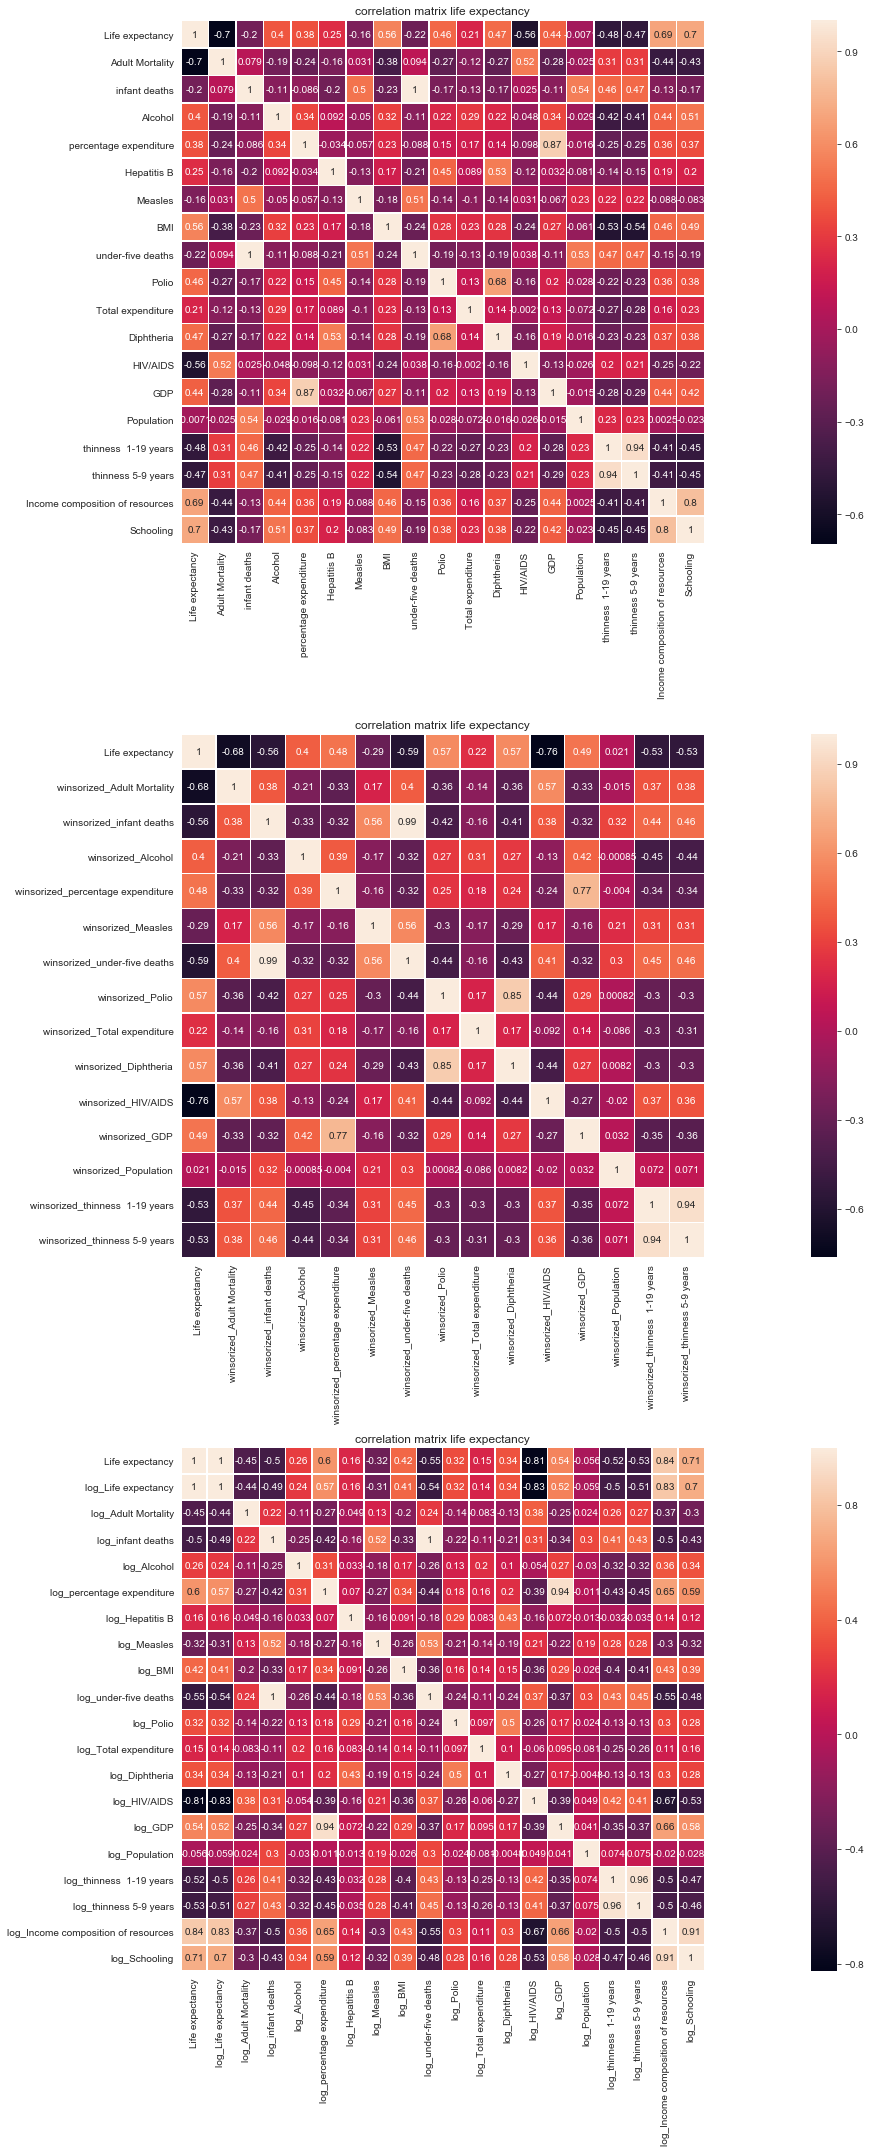

In [32]:
corrmat1_lifeexpectancy = lifeexpectancy_df[['Life expectancy', 'Adult Mortality', 
                                            'infant deaths', 'Alcohol', 'percentage expenditure', 
                                            'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 
                                            'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 
                                            'GDP', 'Population', 'thinness  1-19 years', 
                                            'thinness 5-9 years', 'Income composition of resources', 
                                            'Schooling']].corr()

corrmat2_lifeexpectancy = lifeexpectancy_df[['Life expectancy','winsorized_Adult Mortality', 
                                             'winsorized_infant deaths', 'winsorized_Alcohol', 
                                             'winsorized_percentage expenditure', 'winsorized_Measles', 
                                             'winsorized_under-five deaths', 'winsorized_Polio', 
                                             'winsorized_Total expenditure', 'winsorized_Diphtheria', 
                                             'winsorized_HIV/AIDS', 'winsorized_GDP', 'winsorized_Population', 
                                             'winsorized_thinness  1-19 years','winsorized_thinness 5-9 years']].corr()

corrmat3_lifeexpectancy = lifeexpectancy_df[['Life expectancy','log_Life expectancy',
                                             'log_Adult Mortality', 'log_infant deaths', 'log_Alcohol',
                                             'log_percentage expenditure', 'log_Hepatitis B', 'log_Measles',
                                             'log_BMI', 'log_under-five deaths', 'log_Polio', 'log_Total expenditure', 
                                             'log_Diphtheria', 'log_HIV/AIDS', 'log_GDP', 'log_Population', 
                                             'log_thinness  1-19 years', 'log_thinness 5-9 years',
                                             'log_Income composition of resources', 'log_Schooling']].corr()


plt.figure(figsize=(30,30))
plt.subplot(3,1,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat1_lifeexpectancy, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix life expectancy")
    
plt.subplot(3,1,2)
sns.heatmap(corrmat2_lifeexpectancy, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix life expectancy")
    
plt.subplot(3,1,3)
sns.heatmap(corrmat3_lifeexpectancy, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix life expectancy")


plt.tight_layout()
plt.show()

###### Correlation with life expectancy
'log_Income composition of resources': 0.84
'log_HIV/AIDS': -0.81
'log_Schooling: 0.71

###### checking relationships between continuous & categorical variables

In [33]:
lifeexpectancy_df.groupby('Country').mean()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log_under-five deaths,log_Polio,log_Total expenditure,log_Diphtheria,log_GDP,log_Population,log_thinness 1-19 years,log_thinness 5-9 years,log_Income composition of resources,log_Schooling
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2007.5,58.19375,269.0625,78.2500,0.014375,34.960110,64.562500,2362.2500,15.51875,107.5625,...,4.669579,3.674948,2.107323,3.826337,5.525651,14.999122,2.657020,2.536879,-0.885500,2.086865
Albania,2007.5,75.15625,45.0625,0.6875,4.848750,193.259091,98.000000,53.3750,49.06875,0.9375,...,-inf,4.586204,1.781537,4.585569,7.007840,11.930838,0.464554,0.516384,-0.343932,2.489832
Algeria,2007.5,73.61875,108.1875,20.3125,0.495938,236.185241,76.625000,1943.8750,48.74375,23.5000,...,3.156547,4.518189,1.516134,4.519526,7.447351,16.072120,1.806808,1.787094,-0.365232,2.537271
Angola,2007.5,49.01875,328.5625,83.7500,5.650000,102.100268,77.125000,3561.3125,18.01875,132.6250,...,4.874045,3.403143,1.343511,3.532611,7.093231,15.470218,1.506210,1.631635,-0.785948,2.045398
Antigua and Barbuda,2007.5,75.05625,127.5000,0.0000,7.777813,1001.585226,98.062500,0.0000,38.42500,0.0000,...,-inf,4.573478,1.552260,4.588087,8.958244,16.756031,1.230445,1.215991,-inf,-inf
Argentina,2007.5,75.15625,106.0000,10.1250,7.943750,773.038981,81.125000,2.0000,54.98125,11.3750,...,2.423089,4.535911,1.887376,4.524817,8.376922,16.086682,0.069408,-0.053937,-0.230871,2.803006
Armenia,2007.5,73.40000,117.3750,1.0000,3.833438,131.007419,87.562500,274.2500,44.70625,1.0000,...,0.000000,4.400941,1.592392,4.382242,7.064537,12.351483,0.711443,0.747752,-0.360374,2.464920
Australia,2007.5,81.81250,63.1875,1.0000,9.914688,5332.226473,93.406250,103.9375,55.86250,1.3750,...,0.259930,4.375813,2.170223,4.377172,9.760294,12.459978,-0.404847,-0.472288,-0.085521,2.997229
Austria,2007.5,81.48125,65.7500,0.0000,12.174062,4928.439188,81.062500,77.2500,48.28750,0.0000,...,-inf,4.451727,1.139096,4.461469,9.888772,15.364492,0.548297,0.660932,-0.148335,2.733185


In [34]:
avglifeexp_country = lifeexpectancy_df.groupby('Country')['Life expectancy'].mean()
print(avglifeexp_country)

Country
Afghanistan                                             58.19375
Albania                                                 75.15625
Algeria                                                 73.61875
Angola                                                  49.01875
Antigua and Barbuda                                     75.05625
Argentina                                               75.15625
Armenia                                                 73.40000
Australia                                               81.81250
Austria                                                 81.48125
Azerbaijan                                              70.73125
Bahamas                                                 74.28750
Bahrain                                                 75.72500
Bangladesh                                              69.30000
Barbados                                                74.35625
Belarus                                                 69.90625
Belgium          

Too many countries (193), will look at t-test for each country; will groupby 'Status' and look at relationship to life expectancy

In [35]:
lifeexpectancy_df.groupby('Status').mean()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log_under-five deaths,log_Polio,log_Total expenditure,log_Diphtheria,log_GDP,log_Population,log_thinness 1-19 years,log_thinness 5-9 years,log_Income composition of resources,log_Schooling
Status,,,,,,,,,,,,,,,,,,,,,
Developed,2007.500000,79.197852,79.685547,1.494141,9.634141,2703.600380,83.806185,499.005859,51.803906,1.810547,...,-inf,4.519743,1.896465,4.508630,9.217353,14.037858,0.106192,0.042651,-0.167167,2.743066
Developing,2007.522671,67.107997,182.696002,36.384171,3.475699,323.470285,77.424251,2824.926216,35.448454,50.525144,...,-inf,4.259137,1.639137,4.255205,7.250943,14.065024,1.357067,1.357170,-inf,-inf


In [36]:
status = lifeexpectancy_df['Status'].unique()
status_df = lifeexpectancy_df.groupby('Status')
for var in ['Life expectancy', 'log_Income composition of resources', 'log_HIV/AIDS', 'log_Schooling']:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(status)):
        for j in range(i+1, len(status)):
            print("t-test between groups {0} and {1}:".format(status[i], status[j]))
            print(stats.ttest_ind(
                lifeexpectancy_df[lifeexpectancy_df['Status']==status[i]][var], 
                lifeexpectancy_df[lifeexpectancy_df['Status']==status[j]][var]
            ))

------------------------------------------------
Comparisons for variable: Life expectancy
------------------------------------------------
t-test between groups Developing and Developed:
Ttest_indResult(statistic=-29.83135900677773, pvalue=4.960292113465824e-171)
------------------------------------------------
Comparisons for variable: log_Income composition of resources
------------------------------------------------
t-test between groups Developing and Developed:
Ttest_indResult(statistic=nan, pvalue=nan)
------------------------------------------------
Comparisons for variable: log_HIV/AIDS
------------------------------------------------
t-test between groups Developing and Developed:
Ttest_indResult(statistic=17.526379161410958, pvalue=1.7377194389438237e-65)
------------------------------------------------
Comparisons for variable: log_Schooling
------------------------------------------------
t-test between groups Developing and Developed:
Ttest_indResult(statistic=nan, pvalu

There is clearly a significant difference between the Life Expectancy(key metric)in a Developing country and a Developed country. There is also a significant difference between the HIV rate in Developing and Developed countries. 

life expectancy by year? 

In [37]:
year_avg = lifeexpectancy_df.groupby('Year')['Life expectancy'].mean()
print(year_avg)

Year
2000    66.750273
2001    67.128962
2002    67.351366
2003    67.433333
2004    67.646448
2005    68.209290
2006    68.667760
2007    69.036066
2008    69.427869
2009    69.938251
2010    70.048634
2011    70.654098
2012    70.916940
2013    70.978756
2014    71.536612
2015    71.616940
Name: Life expectancy, dtype: float64


?further explore year? does not appear significantly different

##### question 3
In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

##### suitable variables for modeling
'Income composition of resources', 'winsorized_HIV/AIDS', 'Schooling', 'Status' are highly correlated with Life Expectancy. (Note that winsorized_HIV/AIDS is highly NEGATIVELY correlated.)

Noticed in trying to run jb_stats and normal_stats that there were negative numbers in the log_transformed versions which precluded use of boxcox. Returned to original or winsorized versions as appropriate. 

In [38]:
log_income = lifeexpectancy_df['log_Income composition of resources'].describe()
print(log_income)

count    2938.000000
mean            -inf
std              NaN
min             -inf
25%        -0.693147
50%        -0.379797
75%        -0.234322
max        -0.053401
Name: log_Income composition of resources, dtype: float64


In [39]:
org_income = lifeexpectancy_df['Income composition of resources'].describe()
print(org_income)

count    2938.000000
mean        0.634458
std         0.209574
min         0.000000
25%         0.500000
50%         0.684000
75%         0.791107
max         0.948000
Name: Income composition of resources, dtype: float64


In [40]:
win_hiv = lifeexpectancy_df['winsorized_HIV/AIDS'].describe()
print(win_hiv)

count    2938.000000
mean        0.878863
std         1.433147
min         0.100000
25%         0.100000
50%         0.100000
75%         0.800000
max         4.400000
Name: winsorized_HIV/AIDS, dtype: float64


In [41]:
s = lifeexpectancy_df['Income composition of resources']
any(s<0)

False

In [42]:
t = lifeexpectancy_df['winsorized_HIV/AIDS']
any(t<0)

False

In [43]:
v = lifeexpectancy_df['Schooling']
any(v<0)

False

In [44]:
#veify statistically the distributions of log_transformed variables not normally distributed
jb_stats = jarque_bera(np.sqrt(lifeexpectancy_df['Income composition of resources']))
norm_stats = normaltest(np.sqrt(lifeexpectancy_df['Income composition of resources']))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


Jarque-Bera test statistics is 11427.84745502783 and p value is 0.0
Normality test statistics is 1652.4320667719987 and p value is 0.0


In [45]:
jb_stats = jarque_bera(np.sqrt(lifeexpectancy_df['winsorized_HIV/AIDS']))
norm_stats = normaltest(np.sqrt(lifeexpectancy_df['winsorized_HIV/AIDS']))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


Jarque-Bera test statistics is 966.0572068958537 and p value is 0.0
Normality test statistics is 571.0488888577703 and p value is 9.961146698794502e-125


In [46]:

jb_stats = jarque_bera(np.sqrt(lifeexpectancy_df['Schooling']))
norm_stats = normaltest(np.sqrt(lifeexpectancy_df['Schooling']))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 14972.800302211426 and p value is 0.0
Normality test statistics is 1522.2041840396078 and p value is 0.0


Text(0.5, 1.0, 'histogram of Income composition of resources (box-cox transformed)')

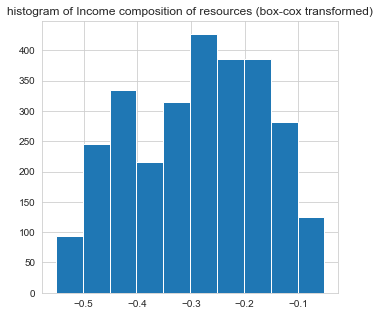

In [47]:
income_boxcox,_ = boxcox(lifeexpectancy_df[lifeexpectancy_df['Income composition of resources'] > 0]['Income composition of resources'])

plt.figure(figsize=(18,5))

# histograms of the box-cox transformed data
plt.subplot(1, 3, 1)
plt.hist(income_boxcox)
plt.title("histogram of Income composition of resources (box-cox transformed)")


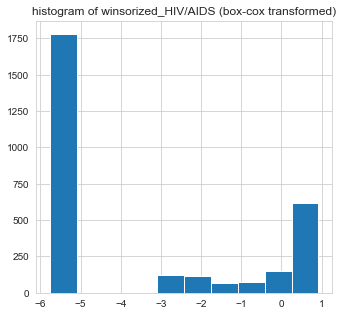

In [48]:
hiv_boxcox,_ = boxcox(lifeexpectancy_df['winsorized_HIV/AIDS'])

plt.figure(figsize=(18,5))


plt.subplot(1, 3, 2)
plt.hist(hiv_boxcox)
plt.title("histogram of winsorized_HIV/AIDS (box-cox transformed)")


plt.show()

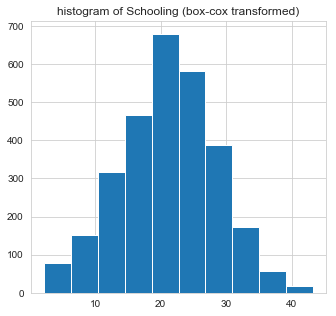

In [49]:
school_boxcox,_ = boxcox(lifeexpectancy_df[lifeexpectancy_df['Schooling'] > 0]['Schooling'])

plt.figure(figsize=(18,5))


plt.subplot(1, 3, 3)
plt.hist(school_boxcox)
plt.title("histogram of Schooling (box-cox transformed)")

plt.show()

In [50]:
#veify statistically the distributions of boxcox variables not normally distributed
jb_stats = jarque_bera(np.sqrt(income_boxcox))
norm_stats = normaltest(np.sqrt(income_boxcox))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.sqrt(hiv_boxcox))
norm_stats = normaltest(np.sqrt(hiv_boxcox))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


jb_stats = jarque_bera(np.sqrt(school_boxcox))
norm_stats = normaltest(np.sqrt(school_boxcox))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is nan and p value is nan
Normality test statistics is nan and p value is nan
Jarque-Bera test statistics is nan and p value is nan
Normality test statistics is nan and p value is nan
Jarque-Bera test statistics is 214.91041919198966 and p value is 0.0
Normality test statistics is 180.05331622635404 and p value is 7.978461565395894e-40


Only 'Schooling'variable is normally distributed. 

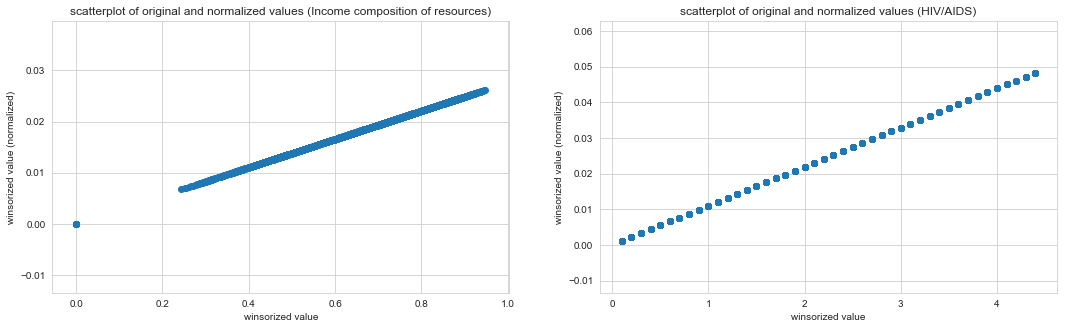

In [51]:
from sklearn.preprocessing import normalize

# normalize the winsorized variables
lifeexpectancy_df['norm_Income composition of resources'] = normalize(np.array(lifeexpectancy_df['Income composition of resources']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_df['norm_winsorized_HIV/AIDS'] = normalize(np.array(lifeexpectancy_df['winsorized_HIV/AIDS']).reshape(1,-1)).reshape(-1,1)

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
plt.scatter(lifeexpectancy_df['Income composition of resources'], lifeexpectancy_df['norm_Income composition of resources'])
plt.title('scatterplot of original and normalized values (Income composition of resources)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')

plt.subplot(1,2,2)
# draw the heatmap using seaborn.
plt.scatter(lifeexpectancy_df['winsorized_HIV/AIDS'], lifeexpectancy_df['norm_winsorized_HIV/AIDS'])
plt.title('scatterplot of original and normalized values (HIV/AIDS)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')


plt.show()

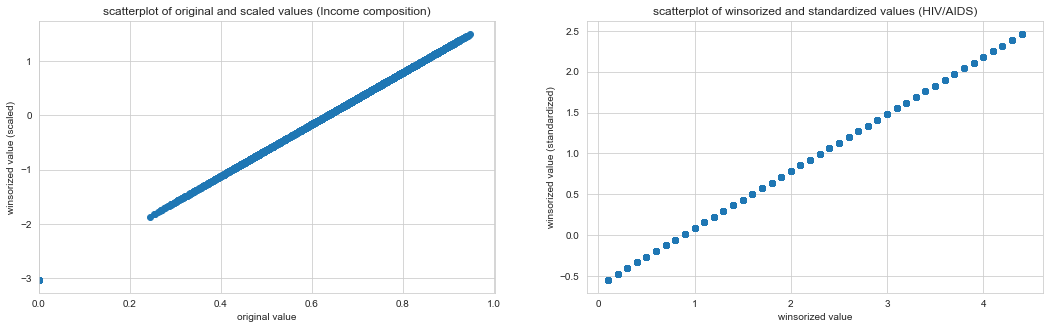

In [52]:
from sklearn.preprocessing import scale

lifeexpectancy_df['scaled_Income composition of resources'] = scale(lifeexpectancy_df['Income composition of resources'])
lifeexpectancy_df['scaled_HIV/AIDS'] = scale(lifeexpectancy_df['winsorized_HIV/AIDS'])

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
plt.scatter(lifeexpectancy_df['Income composition of resources'], lifeexpectancy_df['scaled_Income composition of resources'])
plt.title('scatterplot of original and scaled values (Income composition)')
plt.xlabel('original value')
plt.ylabel('winsorized value (scaled)')
plt.xlim(0.00000001)

plt.subplot(1,2,2)
# draw the heatmap using seaborn.
plt.scatter(lifeexpectancy_df['winsorized_HIV/AIDS'], lifeexpectancy_df['scaled_HIV/AIDS'])
plt.title('scatterplot of winsorized and standardized values (HIV/AIDS)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (standardized)')


plt.show()

In [53]:
#veify statistically the distributions of boxcox variables not normally distributed
jb_stats = jarque_bera(np.sqrt(lifeexpectancy_df['scaled_Income composition of resources']))
norm_stats = normaltest(np.sqrt(lifeexpectancy_df['scaled_Income composition of resources']))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.sqrt(lifeexpectancy_df['scaled_HIV/AIDS']))
norm_stats = normaltest(np.sqrt(lifeexpectancy_df['scaled_HIV/AIDS']))

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


Jarque-Bera test statistics is nan and p value is nan
Normality test statistics is nan and p value is nan
Jarque-Bera test statistics is nan and p value is nan
Normality test statistics is nan and p value is nan


Income & HIV still not normal

### not clear that this adds any value to exploration
pd.get_dummies(lifeexpectancy_df['Status'])

lifeexpectancy_df['Status'] = pd.concat([lifeexpectancy_df, pd.get_dummies(lifeexpectancy_df['Status'])], axis=1)
lifeexpectancy_df

In [70]:
lifeexpectancy_df['Status_category']= lifeexpectancy_df['Status'].map({'Developing': 0, 'Developed': 1})


In [71]:
lifeexpectancy_df.groupby('Status_category').mean()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log_thinness 5-9 years,log_Income composition of resources,log_Schooling,norm_Income composition of resources,norm_winsorized_HIV/AIDS,scaled_Income composition of resources,scaled_HIV/AIDS,scaled_winsor_HIV/AIDS,scaled_Schooling,norm_Schooling
Status_category,,,,,,,,,,,,,,,,,,,,,
0,2007.522671,67.107997,182.696002,36.384171,3.475699,323.470285,77.424251,2824.926216,35.448454,50.525144,...,1.357170,-inf,-inf,0.016276,0.011450,-0.214792,0.114716,0.114716,-0.225034,0.016674
1,2007.500000,79.197852,79.685547,1.494141,9.634141,2703.600380,83.806185,499.005859,51.803906,1.810547,...,0.042651,-0.167167,2.743066,0.023407,0.001098,1.017743,-0.543556,-0.543556,1.066277,0.023027


### how do I use =!  to remove columns instead of adding all the other columns
col_names = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'winsorized_Adult Mortality', 'winsorized_infant deaths',
       'winsorized_Alcohol', 'winsorized_percentage expenditure',
       'winsorized_Measles', 'winsorized_under-five deaths',
       'winsorized_Polio', 'winsorized_Total expenditure',
       'winsorized_Diphtheria', 'winsorized_HIV/AIDS', 'winsorized_GDP',
       'winsorized_Population', 'winsorized_thinness  1-19 years',
       'winsorized_thinness 5-9 years', 'log_percentage expenditure',
       'log_Measles', 'log_HIV/AIDS', 'log_Life expectancy',
       'log_Adult Mortality', 'log_infant deaths', 'log_Alcohol',
       'log_Hepatitis B', 'log_BMI', 'log_under-five deaths', 'log_Polio',
       'log_Total expenditure', 'log_Diphtheria', 'log_GDP', 'log_Population',
       'log_thinness  1-19 years', 'log_thinness 5-9 years',
       'log_Income composition of resources', 'log_Schooling',
       'norm_Income composition of resources', 'norm_winsorized_HIV/AIDS',
       'scaled_Income composition of resources', 'scaled_HIV/AIDS']

##### question 4 
Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

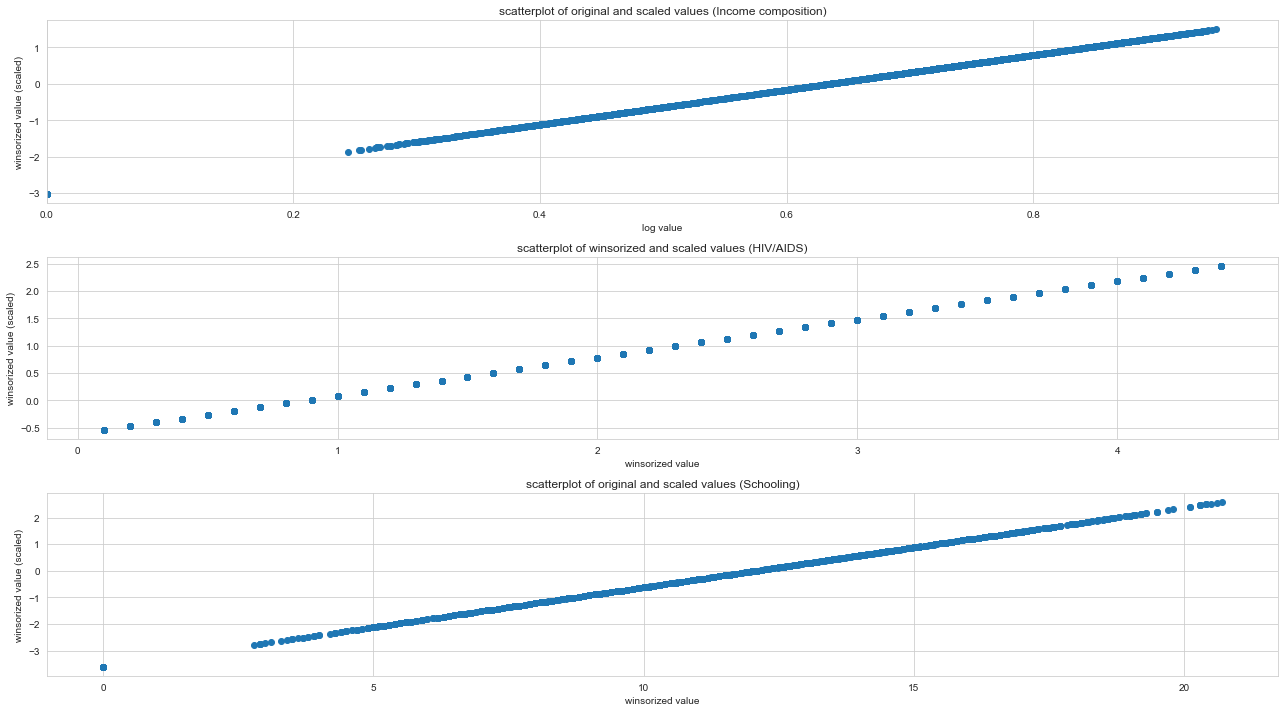

In [60]:
from sklearn.preprocessing import scale

lifeexpectancy_df['scaled_Income composition of resources'] = scale(lifeexpectancy_df['Income composition of resources'])
lifeexpectancy_df['scaled_winsor_HIV/AIDS'] = scale(lifeexpectancy_df['winsorized_HIV/AIDS'])
lifeexpectancy_df['scaled_Schooling'] = scale(lifeexpectancy_df['Schooling'])

plt.figure(figsize=(18,10))

plt.subplot(3,1,1)
plt.scatter(lifeexpectancy_df['Income composition of resources'], lifeexpectancy_df['scaled_Income composition of resources'])
plt.title('scatterplot of original and scaled values (Income composition)')
plt.xlabel('log value')
plt.ylabel('winsorized value (scaled)')
plt.xlim(0.00000001)

plt.subplot(3,1,2)
plt.scatter(lifeexpectancy_df['winsorized_HIV/AIDS'], lifeexpectancy_df['scaled_winsor_HIV/AIDS'])
plt.title('scatterplot of winsorized and scaled values (HIV/AIDS)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (scaled)')

plt.subplot(3,1,3)
plt.scatter(lifeexpectancy_df['Schooling'], lifeexpectancy_df['scaled_Schooling'])
plt.title('scatterplot of original and scaled values (Schooling)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (scaled)')

plt.tight_layout()
plt.show()

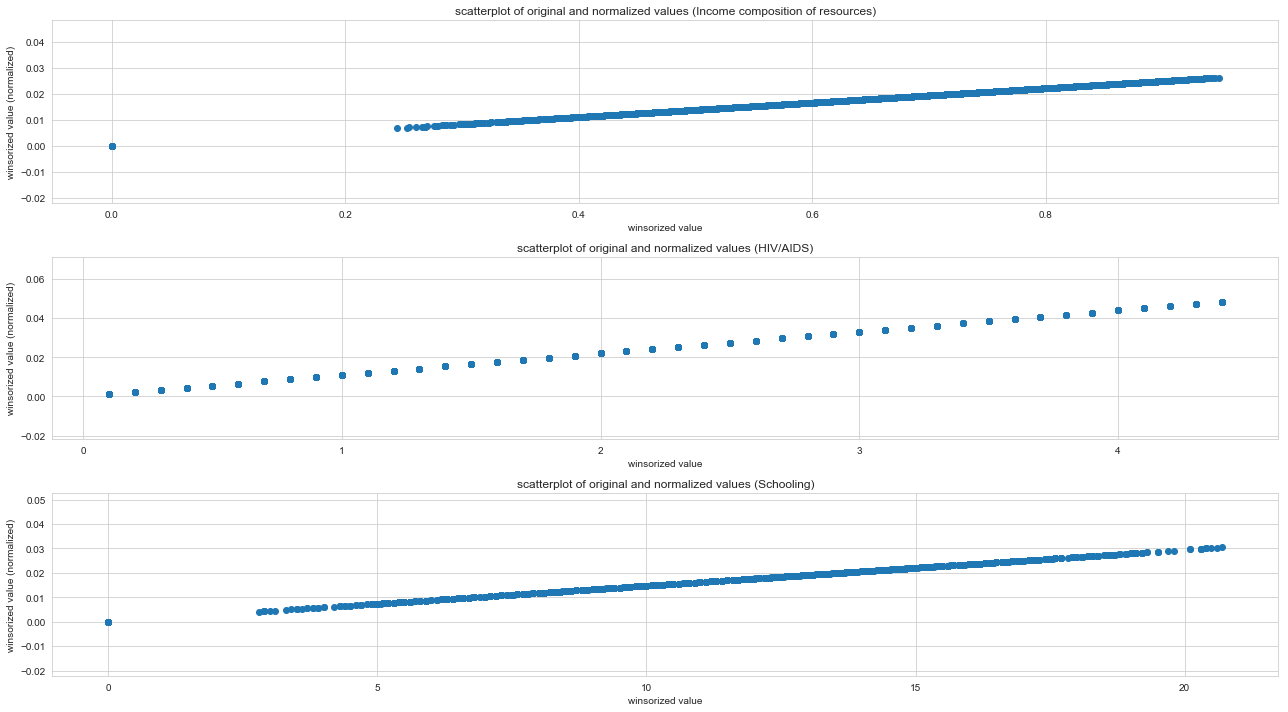

In [68]:
from sklearn.preprocessing import normalize

# normalize the variables
lifeexpectancy_df['norm_Income composition of resources'] = normalize(np.array(lifeexpectancy_df['Income composition of resources']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_df['norm_winsorized_HIV/AIDS'] = normalize(np.array(lifeexpectancy_df['winsorized_HIV/AIDS']).reshape(1,-1)).reshape(-1,1)
lifeexpectancy_df['norm_Schooling'] = normalize(np.array(lifeexpectancy_df['Schooling']).reshape(1, -1)).reshape(-1, 1)


plt.figure(figsize=(18,10))

plt.subplot(3,1,1)
plt.scatter(lifeexpectancy_df['Income composition of resources'], lifeexpectancy_df['norm_Income composition of resources'])
plt.title('scatterplot of original and normalized values (Income composition of resources)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')

plt.subplot(3,1,2)
plt.scatter(lifeexpectancy_df['winsorized_HIV/AIDS'], lifeexpectancy_df['norm_winsorized_HIV/AIDS'])
plt.title('scatterplot of original and normalized values (HIV/AIDS)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')
           
plt.subplot(3,1,3)
plt.scatter(lifeexpectancy_df['Schooling'], lifeexpectancy_df['norm_Schooling'])
plt.title('scatterplot of original and normalized values (Schooling)')
plt.xlabel('winsorized value')
plt.ylabel('winsorized value (normalized)')

plt.tight_layout()
plt.show()

In [73]:
# derive averages by group
lifeexpectancy_df.groupby('Status_category').mean()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log_thinness 5-9 years,log_Income composition of resources,log_Schooling,norm_Income composition of resources,norm_winsorized_HIV/AIDS,scaled_Income composition of resources,scaled_HIV/AIDS,scaled_winsor_HIV/AIDS,scaled_Schooling,norm_Schooling
Status_category,,,,,,,,,,,,,,,,,,,,,
0,2007.522671,67.107997,182.696002,36.384171,3.475699,323.470285,77.424251,2824.926216,35.448454,50.525144,...,1.357170,-inf,-inf,0.016276,0.011450,-0.214792,0.114716,0.114716,-0.225034,0.016674
1,2007.500000,79.197852,79.685547,1.494141,9.634141,2703.600380,83.806185,499.005859,51.803906,1.810547,...,0.042651,-0.167167,2.743066,0.023407,0.001098,1.017743,-0.543556,-0.543556,1.066277,0.023027


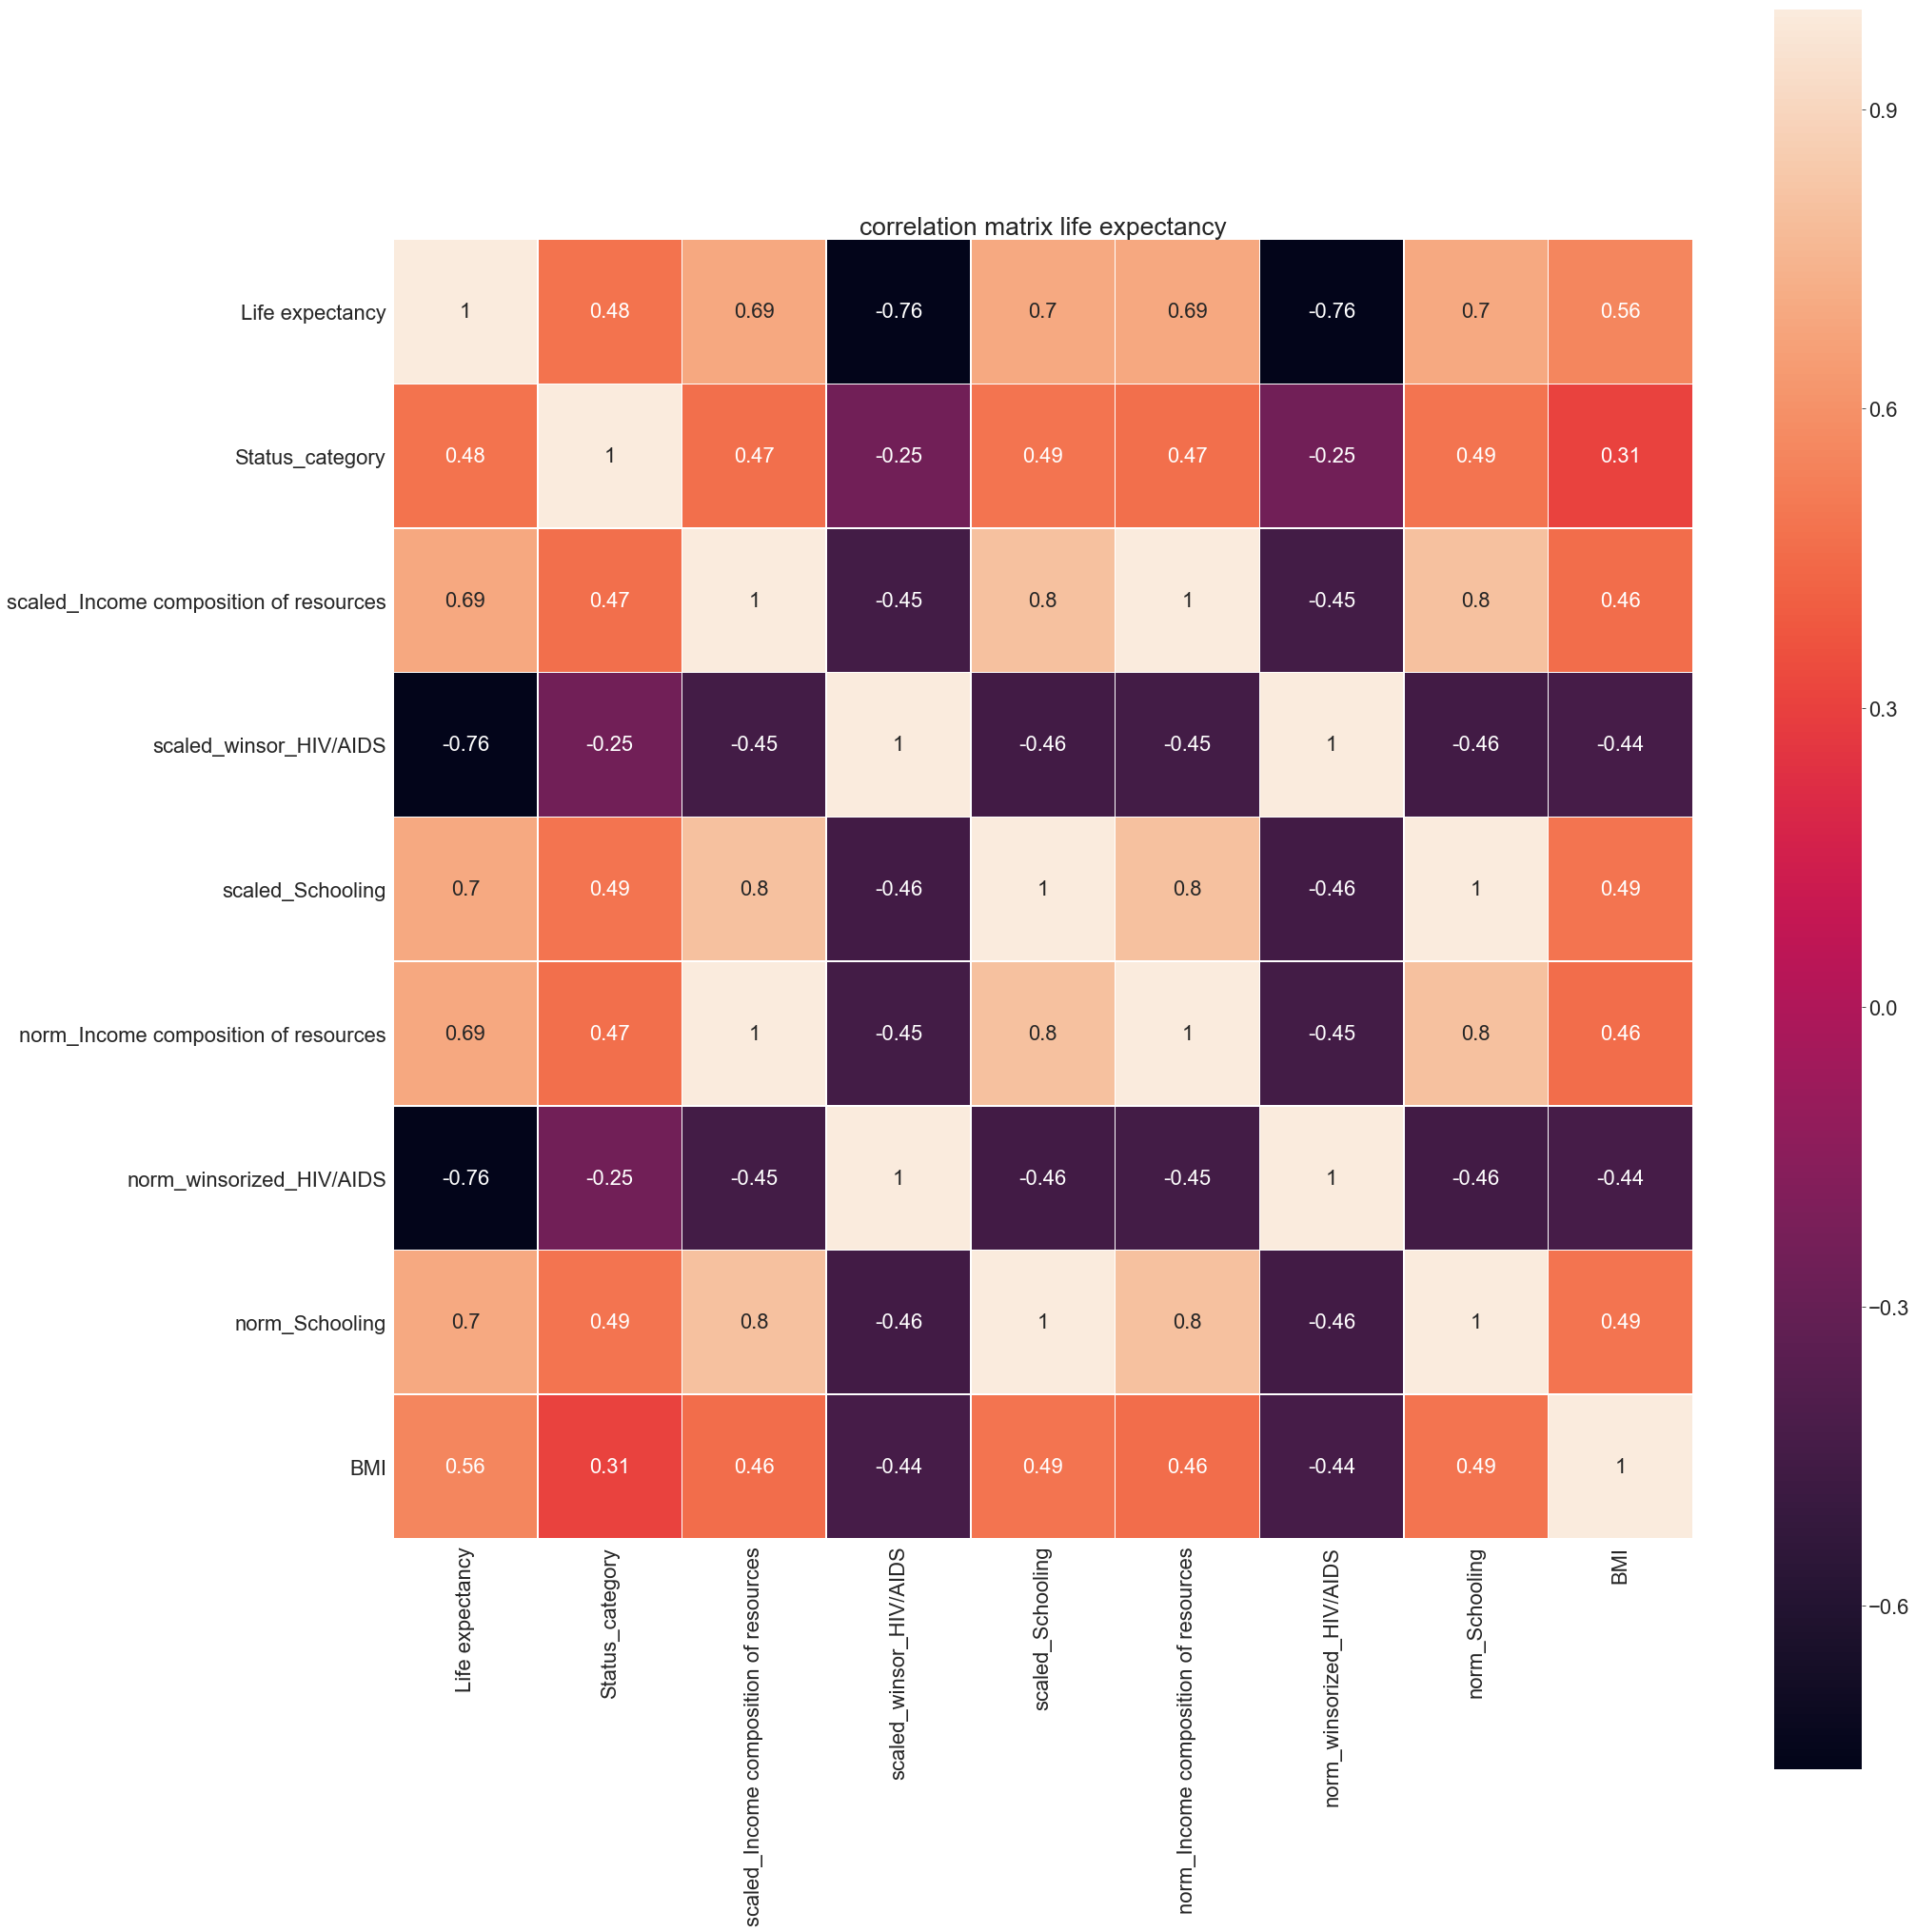

In [75]:
corrmat1_lifeexpectancy = lifeexpectancy_df[['Life expectancy', 'Status_category',
                                             'scaled_Income composition of resources', 
                                             'scaled_winsor_HIV/AIDS', 'scaled_Schooling',
                                             'norm_Income composition of resources', 
                                             'norm_winsorized_HIV/AIDS', 'norm_Schooling',
                                             'BMI']].corr()


plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 22})
plt.subplot(1,1,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat1_lifeexpectancy, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix life expectancy")

plt.tight_layout()
plt.show()

The features of Income composition and Schooling appear to be positively correlated with Life Expectancy and the value of HIV/AIDS appears to be strongly NEGATIVELY correlated with Life expectancy. Although there is a significant difference in the life expectancy between Developing and Developed countries, it does not appear to be strongly correlated with Life expectancy. 